# Analyse des données sur Thoth AI
## Projet HAII - M2 AI2D Sorbonne Université

---

Les expériences ont été menées avec $N=6$ candidats, que nous remercions chaleureusement.\
Nous rappelons les hypothèses testées, mentionnées dans le rapport.

## Hypothèses Testées

1. **H1 (Performance)** : Team Uplfit > 0 (synergie humain-IA)
2. **H2 (Calibration)** : Corrélation entre user_confidence et correct > 0.5
3. **H3 (Abstention)** : Corrélation entre taux abstention et variance des fonds
4. **H4 (Convergence)** : Feedback multiplier stable en fonction des trials
5. **H5 (Reliance)** : Taux d'acceptation décroissant selon incertitude (low > medium > high)

---
## Chargement et lecture des fichiers

In [4]:
import os
import glob
import pandas as pd
import numpy as np
from IPython.display import display

csv_paths = sorted(glob.glob('logs/*.csv')) # dans dossier logs
print(f'Found {len(csv_paths)} CSV files in logs/')

datasets = {
    'by_file': {},
    'combined': None,
    'summary': None,
    'n_files': 0
}

bool_cols = ['precondition_ok', 'abstained', 'fallback_used']
condition_order = ['H_only', 'H_plus_IA', 'AI_only']

summaries = []
dfs = []

for p in csv_paths:
    name = os.path.basename(p)
    try:
        df = pd.read_csv(p)
        df.columns = [c.strip() for c in df.columns]

        for col in bool_cols:
            if col in df.columns:
                df[col] = df[col].astype(str).str.strip().replace(
                    {'True': True, 'False': False, 'true': True, 'false': False, '1': True, '0': False, 'nan': None, 'None': None}
                )

        # Numeric and datetime coercion
        for num in ['decision_time_ms', 'user_confidence']:
            if num in df.columns:
                df[num] = pd.to_numeric(df[num], errors='coerce')
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

        # categorical ordering for condition if present
        if 'condition' in df.columns:
            df['condition'] = pd.Categorical(df['condition'], categories=condition_order, ordered=True)

        datasets['by_file'][name] = df
        dfs.append(df)

        summaries.append({
            'file': name,
            'rows': len(df),
            'cols': len(df.columns),
            'unique_sessions': int(df['session_id'].nunique()) if 'session_id' in df.columns else np.nan,
            'unique_trials': int(df['trial_id'].nunique()) if 'trial_id' in df.columns else np.nan
        })

        print(f'Loaded {name}: rows={len(df)}, cols={len(df.columns)}')
    except Exception as e:
        print(f'Failed to load {name}: {e}')

if dfs:
    combined = pd.concat(dfs, ignore_index=True, sort=False)
    datasets['combined'] = combined
    datasets['summary'] = pd.DataFrame(summaries)
    datasets['n_files'] = len(datasets['by_file'])

    print('\nSummary of loaded files:')
    display(datasets['summary'])
    print('\nCombined dataframe shape:', combined.shape)
else:
    print('No dataframes loaded from events_samples/')

def get_file(fname):
    """Return cleaned DataFrame for a given filename (basename)."""
    return datasets['by_file'].get(fname)


def preview(fname, n=5):
    df = get_file(fname)
    if df is None:
        print('File not found:', fname)
    else:
        display(df.head(n))


def save_combined(path='data_clean_allcsv.csv'):
    if datasets['combined'] is None:
        print('No combined dataframe to save')
    else:
        datasets['combined'].to_csv(path, index=False)
        print('Saved', path)

print(f"\nDatasets ready : {datasets['n_files']} files loaded.")


Found 9 CSV files in logs/
Loaded events_sample(1)(2).csv: rows=59, cols=18
Loaded events_sample(2)(1).csv: rows=148, cols=18
Loaded events_sample(2).csv: rows=620, cols=18
Loaded events_sample(3).csv: rows=44, cols=18
Loaded events_sample(4).csv: rows=85, cols=18
Loaded events_sample(5).csv: rows=35, cols=18
Loaded events_sample(6).csv: rows=64, cols=18
Loaded events_sample6.csv: rows=71, cols=18
Loaded events_sample_tom7.csv: rows=80, cols=18

Summary of loaded files:


,file,rows,cols,unique_sessions,unique_trials
0,events_sample(1)(2).csv,59,18,1,17
1,events_sample(2)(1).csv,148,18,1,19
2,events_sample(2).csv,620,18,1,26
3,events_sample(3).csv,44,18,1,14
4,events_sample(4).csv,85,18,1,10
5,events_sample(5).csv,35,18,1,12
6,events_sample(6).csv,64,18,1,15
7,events_sample6.csv,71,18,1,6
8,events_sample_tom7.csv,80,18,1,6



Combined dataframe shape: (1206, 18)

Datasets ready : 9 files loaded.


In [5]:
from IPython.display import display

print('\n=== Clés dans datasets ===')
for k in datasets.keys():
    print(f"- {k}: type={type(datasets[k]).__name__}")

print('\n=== Détail par fichier (datasets["by_file"]) ===')
if datasets.get('by_file'):
    for fname, df in datasets['by_file'].items():
        print(f"\n-- {fname}")
        try:
            print(f"   shape: {df.shape}")
            print(f"   columns ({len(df.columns)}): {list(df.columns)}")
            dtypes = df.dtypes.astype(str).value_counts().to_dict()
            print(f"   dtypes: {dtypes}")
            for col in ['session_id', 'trial_id', 'event_type', 'condition']:
                if col in df.columns:
                    print(f"   {col}: unique={df[col].nunique()} | missing={df[col].isna().sum()}")
            with pd.option_context('display.max_columns', 10):
                display(df.head(2))
        except Exception as e:
            print(f"   (error inspecting file: {e})")
else:
    print('!!!Pas de fichiers dans datasets')

print('\n=== datasets["summary"] ===')
if datasets.get('summary') is not None:
    display(datasets['summary'])
else:
    print('Aucun résumé disponible')

print('\n=== datasets["combined"] ===')
if datasets.get('combined') is not None:
    dfc = datasets['combined']
    print(f"combined shape: {dfc.shape}")
    print(f"columns ({len(dfc.columns)}): {list(dfc.columns)}")
    print('\ncolumn dtypes (top 20):')
    display(dfc.dtypes.head(20))
    print('\nmissing counts (key columns):')
    for col in ['session_id', 'trial_id', 'event_type', 'condition']:
        if col in dfc.columns:
            print(f"- {col}: missing={dfc[col].isna().sum()} | unique={dfc[col].nunique()}")
    print('\nCombined sample:')
    with pd.option_context('display.max_columns', 40):
        display(dfc.head(5))
else:
    print('Aucun DataFrame combined disponible')

print('\n=== Fin du diagnostic datasets ===')



=== Clés dans datasets ===
- by_file: type=dict
- combined: type=DataFrame
- summary: type=DataFrame
- n_files: type=int

=== Détail par fichier (datasets["by_file"]) ===

-- events_sample(1)(2).csv
   shape: (59, 18)
   columns (18): ['timestamp', 'session_id', 'trial_id', 'condition', 'event_type', 'trigger', 'ai_output', 'ai_uncertainty', 'explanation_variant', 'human_action', 'user_confidence', 'correct', 'decision_time_ms', 'slice_id', 'precondition_ok', 'abstained', 'fallback_used', 'notes']
   dtypes: {'object': 12, 'float64': 4, 'datetime64[ns, UTC]': 1, 'category': 1}
   session_id: unique=1 | missing=1
   trial_id: unique=17 | missing=1
   event_type: unique=4 | missing=1
   condition: unique=3 | missing=1


,timestamp,session_id,trial_id,condition,event_type,...,slice_id,precondition_ok,abstained,fallback_used,notes
0,2026-01-20 16:17:45.866000+00:00,1.267113e+09,1.0,H_only,user_action,...,novice,True,False,False,Investissement dans Apple
1,2026-01-20 16:17:56.275000+00:00,1.267113e+09,2.0,H_plus_IA,show_hint,...,novice,True,False,False,Recommendation: Amazon



-- events_sample(2)(1).csv
   shape: (148, 18)
   columns (18): ['timestamp', 'session_id', 'trial_id', 'condition', 'event_type', 'trigger', 'ai_output', 'ai_uncertainty', 'explanation_variant', 'human_action', 'user_confidence', 'correct', 'decision_time_ms', 'slice_id', 'precondition_ok', 'abstained', 'fallback_used', 'notes']
   dtypes: {'object': 12, 'float64': 4, 'datetime64[ns, UTC]': 1, 'category': 1}
   session_id: unique=1 | missing=1
   trial_id: unique=19 | missing=1
   event_type: unique=4 | missing=1
   condition: unique=3 | missing=1


,timestamp,session_id,trial_id,condition,event_type,...,slice_id,precondition_ok,abstained,fallback_used,notes
0,2026-01-20 15:06:53.928000+00:00,93256981.0,0.0,H_plus_IA,hover_prediction,...,novice,True,False,False,Recommendation: Netflix
1,2026-01-20 15:06:55.993000+00:00,93256981.0,0.0,H_plus_IA,hover_prediction,...,novice,True,True,True,Recommendation: Amazon



-- events_sample(2).csv
   shape: (620, 18)
   columns (18): ['timestamp', 'session_id', 'trial_id', 'condition', 'event_type', 'trigger', 'ai_output', 'ai_uncertainty', 'explanation_variant', 'human_action', 'user_confidence', 'correct', 'decision_time_ms', 'slice_id', 'precondition_ok', 'abstained', 'fallback_used', 'notes']
   dtypes: {'object': 12, 'float64': 4, 'datetime64[ns, UTC]': 1, 'category': 1}
   session_id: unique=1 | missing=1
   trial_id: unique=26 | missing=1
   event_type: unique=4 | missing=1
   condition: unique=3 | missing=1


,timestamp,session_id,trial_id,condition,event_type,...,slice_id,precondition_ok,abstained,fallback_used,notes
0,2026-01-20 16:42:55.869000+00:00,3294668.0,1.0,H_plus_IA,show_hint,...,novice,True,False,False,Recommendation: Tesla
1,2026-01-20 16:43:02.234000+00:00,3294668.0,1.0,H_plus_IA,user_action,...,novice,True,False,False,Investissement dans Tesla



-- events_sample(3).csv
   shape: (44, 18)
   columns (18): ['timestamp', 'session_id', 'trial_id', 'condition', 'event_type', 'trigger', 'ai_output', 'ai_uncertainty', 'explanation_variant', 'human_action', 'user_confidence', 'correct', 'decision_time_ms', 'slice_id', 'precondition_ok', 'abstained', 'fallback_used', 'notes']
   dtypes: {'object': 12, 'float64': 4, 'datetime64[ns, UTC]': 1, 'category': 1}
   session_id: unique=1 | missing=1
   trial_id: unique=14 | missing=1
   event_type: unique=4 | missing=1
   condition: unique=3 | missing=1


,timestamp,session_id,trial_id,condition,event_type,...,slice_id,precondition_ok,abstained,fallback_used,notes
0,2026-01-20 16:30:34.130000+00:00,-925389450.0,1.0,H_plus_IA,show_hint,...,intermediate,True,False,False,Recommendation: Apple
1,2026-01-20 16:30:56.989000+00:00,-925389450.0,1.0,H_plus_IA,hover_prediction,...,intermediate,True,False,False,Recommendation: Apple



-- events_sample(4).csv
   shape: (85, 18)
   columns (18): ['timestamp', 'session_id', 'trial_id', 'condition', 'event_type', 'trigger', 'ai_output', 'ai_uncertainty', 'explanation_variant', 'human_action', 'user_confidence', 'correct', 'decision_time_ms', 'slice_id', 'precondition_ok', 'abstained', 'fallback_used', 'notes']
   dtypes: {'object': 12, 'float64': 4, 'datetime64[ns, UTC]': 1, 'category': 1}
   session_id: unique=1 | missing=1
   trial_id: unique=10 | missing=1
   event_type: unique=4 | missing=1
   condition: unique=3 | missing=1


,timestamp,session_id,trial_id,condition,event_type,...,slice_id,precondition_ok,abstained,fallback_used,notes
0,2026-01-20 16:18:52.003000+00:00,3294668.0,1.0,H_only,user_action,...,novice,True,False,False,Investissement dans Amazon
1,2026-01-20 16:19:10.260000+00:00,3294668.0,1.0,H_only,user_action,...,novice,True,False,False,Investissement dans Tesla



-- events_sample(5).csv
   shape: (35, 18)
   columns (18): ['timestamp', 'session_id', 'trial_id', 'condition', 'event_type', 'trigger', 'ai_output', 'ai_uncertainty', 'explanation_variant', 'human_action', 'user_confidence', 'correct', 'decision_time_ms', 'slice_id', 'precondition_ok', 'abstained', 'fallback_used', 'notes']
   dtypes: {'object': 12, 'float64': 4, 'datetime64[ns, UTC]': 1, 'category': 1}
   session_id: unique=1 | missing=1
   trial_id: unique=12 | missing=1
   event_type: unique=3 | missing=1
   condition: unique=3 | missing=1


,timestamp,session_id,trial_id,condition,event_type,...,slice_id,precondition_ok,abstained,fallback_used,notes
0,2026-01-20 14:07:53.369000+00:00,1.107748e+09,1.0,H_only,user_action,...,intermediate,True,False,False,Investissement dans Apple
1,2026-01-20 14:07:53.885000+00:00,1.107748e+09,1.0,H_only,user_action,...,intermediate,True,False,False,Investissement dans Apple



-- events_sample(6).csv
   shape: (64, 18)
   columns (18): ['timestamp', 'session_id', 'trial_id', 'condition', 'event_type', 'trigger', 'ai_output', 'ai_uncertainty', 'explanation_variant', 'human_action', 'user_confidence', 'correct', 'decision_time_ms', 'slice_id', 'precondition_ok', 'abstained', 'fallback_used', 'notes']
   dtypes: {'object': 12, 'float64': 4, 'datetime64[ns, UTC]': 1, 'category': 1}
   session_id: unique=1 | missing=1
   trial_id: unique=15 | missing=1
   event_type: unique=4 | missing=1
   condition: unique=3 | missing=1


,timestamp,session_id,trial_id,condition,event_type,...,slice_id,precondition_ok,abstained,fallback_used,notes
0,2026-01-20 16:43:34.009000+00:00,-1.253460e+09,1.0,H_plus_IA,show_hint,...,novice,True,False,False,Recommendation: Amazon
1,2026-01-20 16:43:43.271000+00:00,-1.253460e+09,1.0,H_plus_IA,user_action,...,novice,True,False,False,Investissement dans Amazon



-- events_sample6.csv
   shape: (71, 18)
   columns (18): ['timestamp', 'session_id', 'trial_id', 'condition', 'event_type', 'trigger', 'ai_output', 'ai_uncertainty', 'explanation_variant', 'human_action', 'user_confidence', 'correct', 'decision_time_ms', 'slice_id', 'precondition_ok', 'abstained', 'fallback_used', 'notes']
   dtypes: {'object': 12, 'float64': 4, 'datetime64[ns, UTC]': 1, 'category': 1}
   session_id: unique=1 | missing=1
   trial_id: unique=6 | missing=1
   event_type: unique=4 | missing=1
   condition: unique=3 | missing=1


,timestamp,session_id,trial_id,condition,event_type,...,slice_id,precondition_ok,abstained,fallback_used,notes
0,2026-01-20 15:21:32.795000+00:00,3294668.0,1.0,H_only,user_action,...,novice,True,False,False,Investissement dans Apple
1,2026-01-20 15:21:50+00:00,3294668.0,1.0,H_only,user_action,...,novice,True,False,False,Investissement dans Netflix



-- events_sample_tom7.csv
   shape: (80, 18)
   columns (18): ['timestamp', 'session_id', 'trial_id', 'condition', 'event_type', 'trigger', 'ai_output', 'ai_uncertainty', 'explanation_variant', 'human_action', 'user_confidence', 'correct', 'decision_time_ms', 'slice_id', 'precondition_ok', 'abstained', 'fallback_used', 'notes']
   dtypes: {'object': 12, 'float64': 4, 'datetime64[ns, UTC]': 1, 'category': 1}
   session_id: unique=1 | missing=1
   trial_id: unique=6 | missing=1
   event_type: unique=4 | missing=1
   condition: unique=3 | missing=1


,timestamp,session_id,trial_id,condition,event_type,...,slice_id,precondition_ok,abstained,fallback_used,notes
0,2026-01-20 15:46:56.460000+00:00,3294668.0,1.0,H_only,user_action,...,novice,True,False,False,Investissement dans Apple
1,2026-01-20 15:46:58.322000+00:00,3294668.0,1.0,H_only,user_action,...,novice,True,False,False,Investissement dans Apple



=== datasets["summary"] ===


,file,rows,cols,unique_sessions,unique_trials
0,events_sample(1)(2).csv,59,18,1,17
1,events_sample(2)(1).csv,148,18,1,19
2,events_sample(2).csv,620,18,1,26
3,events_sample(3).csv,44,18,1,14
4,events_sample(4).csv,85,18,1,10
5,events_sample(5).csv,35,18,1,12
6,events_sample(6).csv,64,18,1,15
7,events_sample6.csv,71,18,1,6
8,events_sample_tom7.csv,80,18,1,6



=== datasets["combined"] ===
combined shape: (1206, 18)
columns (18): ['timestamp', 'session_id', 'trial_id', 'condition', 'event_type', 'trigger', 'ai_output', 'ai_uncertainty', 'explanation_variant', 'human_action', 'user_confidence', 'correct', 'decision_time_ms', 'slice_id', 'precondition_ok', 'abstained', 'fallback_used', 'notes']

column dtypes (top 20):


timestamp              datetime64[ns, UTC]
session_id                         float64
trial_id                           float64
condition                         category
event_type                          object
trigger                             object
ai_output                           object
ai_uncertainty                      object
explanation_variant                 object
human_action                        object
user_confidence                    float64
correct                             object
decision_time_ms                   float64
slice_id                            object
precondition_ok                     object
abstained                           object
fallback_used                       object
notes                               object
dtype: object


missing counts (key columns):
- session_id: missing=9 | unique=6
- trial_id: missing=9 | unique=27
- event_type: missing=9 | unique=4
- condition: missing=9 | unique=3

Combined sample:


,timestamp,session_id,trial_id,condition,event_type,trigger,ai_output,ai_uncertainty,explanation_variant,human_action,user_confidence,correct,decision_time_ms,slice_id,precondition_ok,abstained,fallback_used,notes
0,2026-01-20 16:17:45.866000+00:00,1.267113e+09,1.0,H_only,user_action,on_demand,none,na,off,ignore,0.5,NaN,12292.0,novice,True,False,False,Investissement dans Apple
1,2026-01-20 16:17:56.275000+00:00,1.267113e+09,2.0,H_plus_IA,show_hint,on_demand,shown,low,factors,NaN,NaN,NaN,NaN,novice,True,False,False,Recommendation: Amazon
2,2026-01-20 16:18:04.645000+00:00,1.267113e+09,2.0,H_plus_IA,user_action,on_demand,shown,low,factors,accept,0.5,NaN,8370.0,novice,True,False,False,Investissement dans Amazon
3,2026-01-20 16:18:17.662000+00:00,1.267113e+09,1.0,AI_only,submit,on_demand,shown,high,factors,none,NaN,N,NaN,novice,True,True,True,Plus-value (3m): -32.08% sur Apple
4,2026-01-20 16:18:37.638000+00:00,1.267113e+09,2.0,AI_only,submit,on_demand,shown,high,factors,none,NaN,N,NaN,novice,True,True,True,Plus-value (3m): 3.75% sur Amazon



=== Fin du diagnostic datasets ===


---
## Statistiques globales pour tous les utilisateurs

### Utilisateurs spécifiques

Analyse des sessions spécifiques: [1267112919.0, -925389450.0]


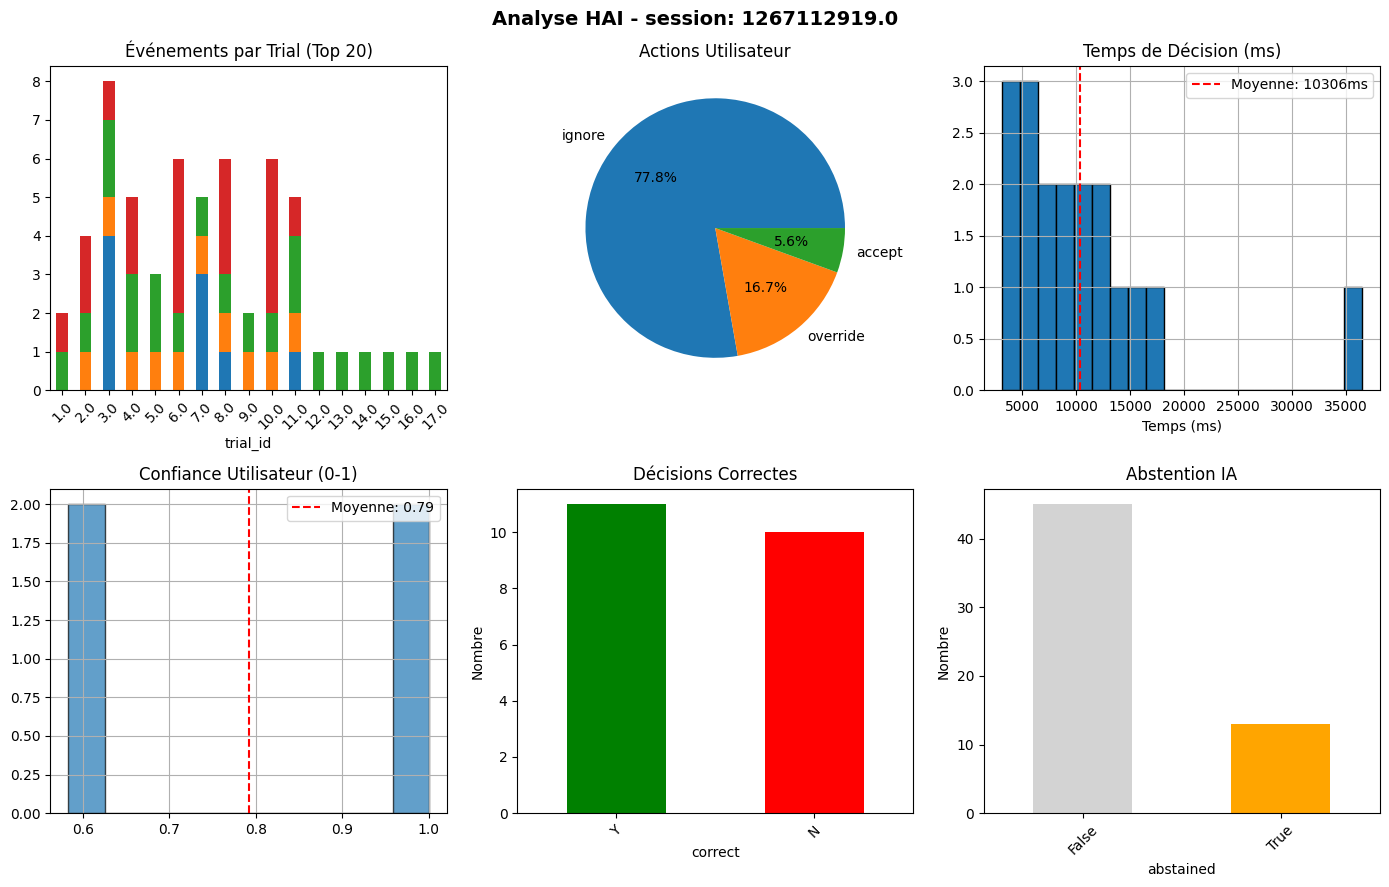

Graphique utilisateur sauvegardé : user_graphs_allcsv/analyse_hai_user_1267112919_0.png


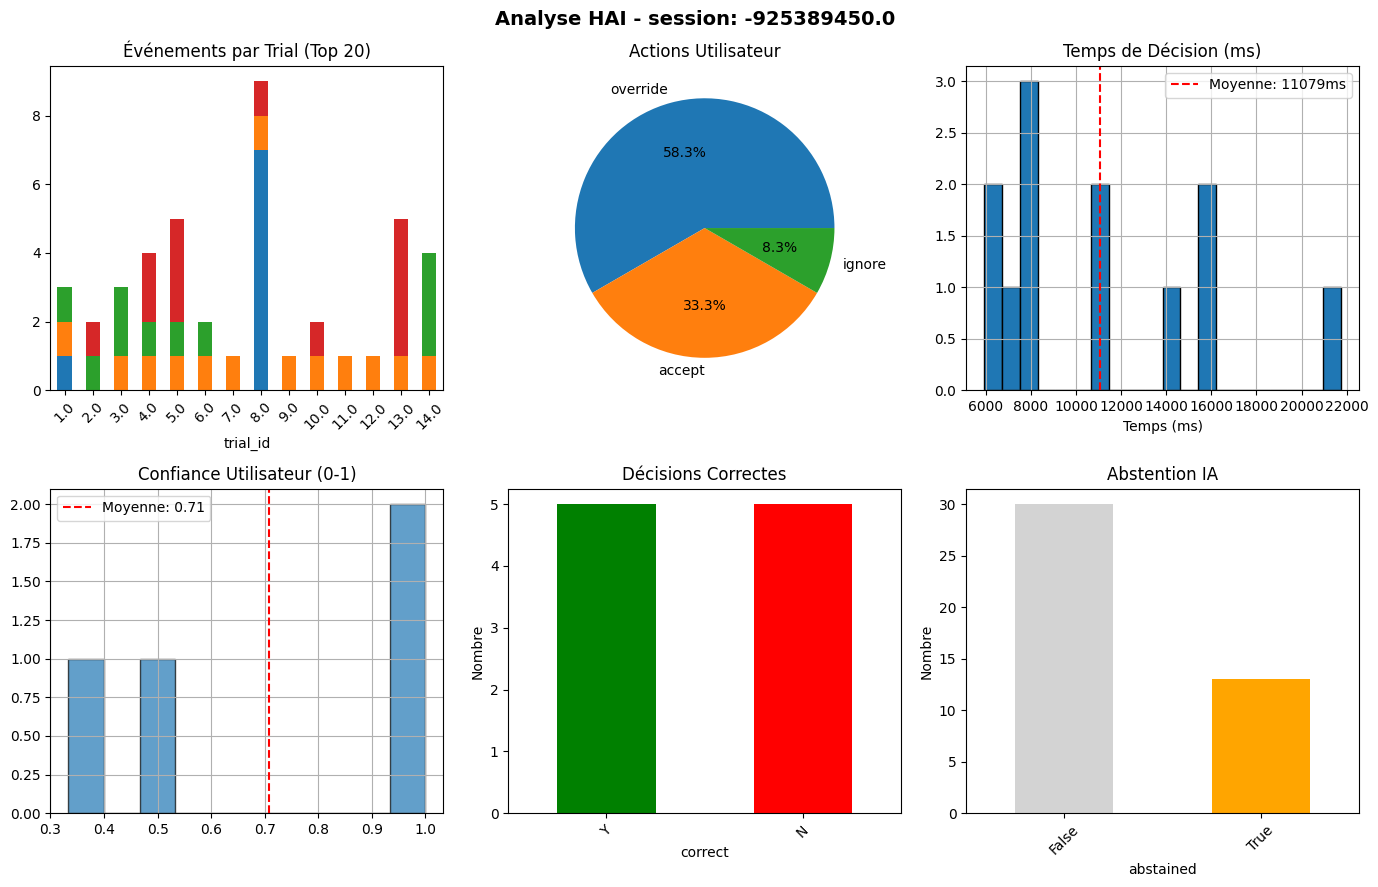

Graphique utilisateur sauvegardé : user_graphs_allcsv/analyse_hai_user_-925389450_0.png

Analyse terminée pour sessions : [1267112919.0, -925389450.0]
Graphiques dans: user_graphs_allcsv/


In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

OUT_DIR = 'user_graphs_allcsv'
os.makedirs(OUT_DIR, exist_ok=True)

df = datasets['combined']
if df is None:
    print("datasets['combined'] non disponible")
else:
    chosen_sessions = [1267112919.0, -925389450.0]
    print(f'Analyse des sessions spécifiques: {chosen_sessions}')
    
    for SESSION_ID in chosen_sessions:
        user_df = df[df['session_id'] == SESSION_ID].copy()
        if user_df.empty:
            print(f'No events found for session_id={SESSION_ID}')
            continue

        bool_cols = ['precondition_ok', 'abstained', 'fallback_used']
        for col in bool_cols:
            if col in user_df.columns:
                user_df[col] = user_df[col].astype(str).map({
                    'True': True, 'False': False, 'true': True, 'false': False, 'nan': None
                })
        if 'decision_time_ms' in user_df.columns:
            user_df['decision_time_ms'] = pd.to_numeric(user_df['decision_time_ms'], errors='coerce')
        if 'user_confidence' in user_df.columns:
            user_df['user_confidence'] = pd.to_numeric(user_df['user_confidence'], errors='coerce')

        user_actions = user_df[user_df.get('event_type') == 'user_action'] if 'event_type' in user_df.columns else pd.DataFrame()
        submits = user_df[user_df.get('event_type') == 'submit'] if 'event_type' in user_df.columns else pd.DataFrame()

        fig, axes = plt.subplots(2, 3, figsize=(14, 9))
        fig.suptitle(f'Analyse HAI - session: {SESSION_ID}', fontsize=14, fontweight='bold')

        ax1 = axes[0,0]
        if 'trial_id' in user_df.columns and 'event_type' in user_df.columns:
            try:
                top_trials = user_df['trial_id'].value_counts().head(20).index
                trial_sample = user_df[user_df['trial_id'].isin(top_trials)]
                trial_events = trial_sample.groupby(['trial_id', 'event_type']).size().unstack(fill_value=0)
                if not trial_events.empty:
                    trial_events.plot(ax=ax1, kind='bar', stacked=True, legend=False)
                    ax1.set_title('Événements par Trial (Top 20)')
                    ax1.tick_params(axis='x', rotation=45)
                else:
                    ax1.text(0.5, 0.5, "Pas d'événements", ha='center')
            except Exception as e:
                ax1.text(0.5, 0.5, f'Erreur: {e}', ha='center')
        else:
            ax1.text(0.5, 0.5, "Pas de 'trial_id' ou 'event_type'", ha='center')

        ax2 = axes[0,1]
        if len(user_actions) > 0 and 'human_action' in user_actions.columns:
            user_actions['human_action'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
            ax2.set_title('Actions Utilisateur')
            ax2.set_ylabel('')
        else:
            ax2.text(0.5, 0.5, 'Pas d\'actions utilisateur', ha='center')

        ax3 = axes[0,2]
        if len(user_actions) > 0 and 'decision_time_ms' in user_actions.columns:
            valid_times = user_actions['decision_time_ms'].dropna()
            if len(valid_times) > 0:
                valid_times.hist(bins=20, ax=ax3, edgecolor='black')
                ax3.axvline(valid_times.mean(), color='red', linestyle='--', label=f'Moyenne: {valid_times.mean():.0f}ms')
                ax3.set_title('Temps de Décision (ms)')
                ax3.set_xlabel('Temps (ms)')
                ax3.legend()
            else:
                ax3.text(0.5, 0.5, 'Pas de temps valide', ha='center')
        else:
            ax3.text(0.5, 0.5, 'Pas de decision_time', ha='center')

        ax4 = axes[1,0]
        if len(submits) > 0 and 'user_confidence' in submits.columns:
            valid_conf = submits['user_confidence'].dropna()
            if len(valid_conf) > 0:
                valid_conf.hist(bins=10, ax=ax4, edgecolor='black', alpha=0.7)
                ax4.axvline(valid_conf.mean(), color='red', linestyle='--', label=f'Moyenne: {valid_conf.mean():.2f}')
                ax4.set_title('Confiance Utilisateur (0-1)')
                ax4.legend()
            else:
                ax4.text(0.5, 0.5, 'Pas de confiance valide', ha='center')
        else:
            ax4.text(0.5, 0.5, 'Pas de submits utilisateur', ha='center')

        ax5 = axes[1,1]
        if len(submits) > 0 and 'correct' in submits.columns:
            submits['correct'].value_counts().plot(kind='bar', ax=ax5, color=['green', 'red'])
            ax5.set_title('Décisions Correctes')
            ax5.set_ylabel('Nombre')
            ax5.tick_params(axis='x', rotation=45)
        else:
            ax5.text(0.5, 0.5, 'Pas de submits utilisateur', ha='center')

        ax6 = axes[1,2] # axe abstention
        if 'abstained' in user_df.columns:
            abstentions = user_df['abstained'].value_counts()
            if len(abstentions) > 0:
                colors = ['orange' if idx else 'lightgray' for idx in abstentions.index]
                abstentions.plot(kind='bar', ax=ax6, color=colors)
                ax6.set_title('Abstention IA')
                ax6.set_ylabel('Nombre')
                ax6.tick_params(axis='x', rotation=45)
            else:
                ax6.text(0.5, 0.5, "Pas d'abstention", ha='center')
        else:
            ax6.text(0.5, 0.5, 'Colonne absente', ha='center')

        plt.tight_layout()
        safe_id = str(SESSION_ID).replace('/', '_').replace('.', '_')
        out_path = os.path.join(OUT_DIR, f'analyse_hai_user_{safe_id}.png')
        plt.savefig(out_path, dpi=200, bbox_inches='tight')
        plt.show()
        print(f'Graphique utilisateur sauvegardé : {out_path}')

    print(f"\nAnalyse terminée pour sessions : {chosen_sessions}")
    print(f"Graphiques dans: {OUT_DIR}/")


### Groupe d'utilisateurs

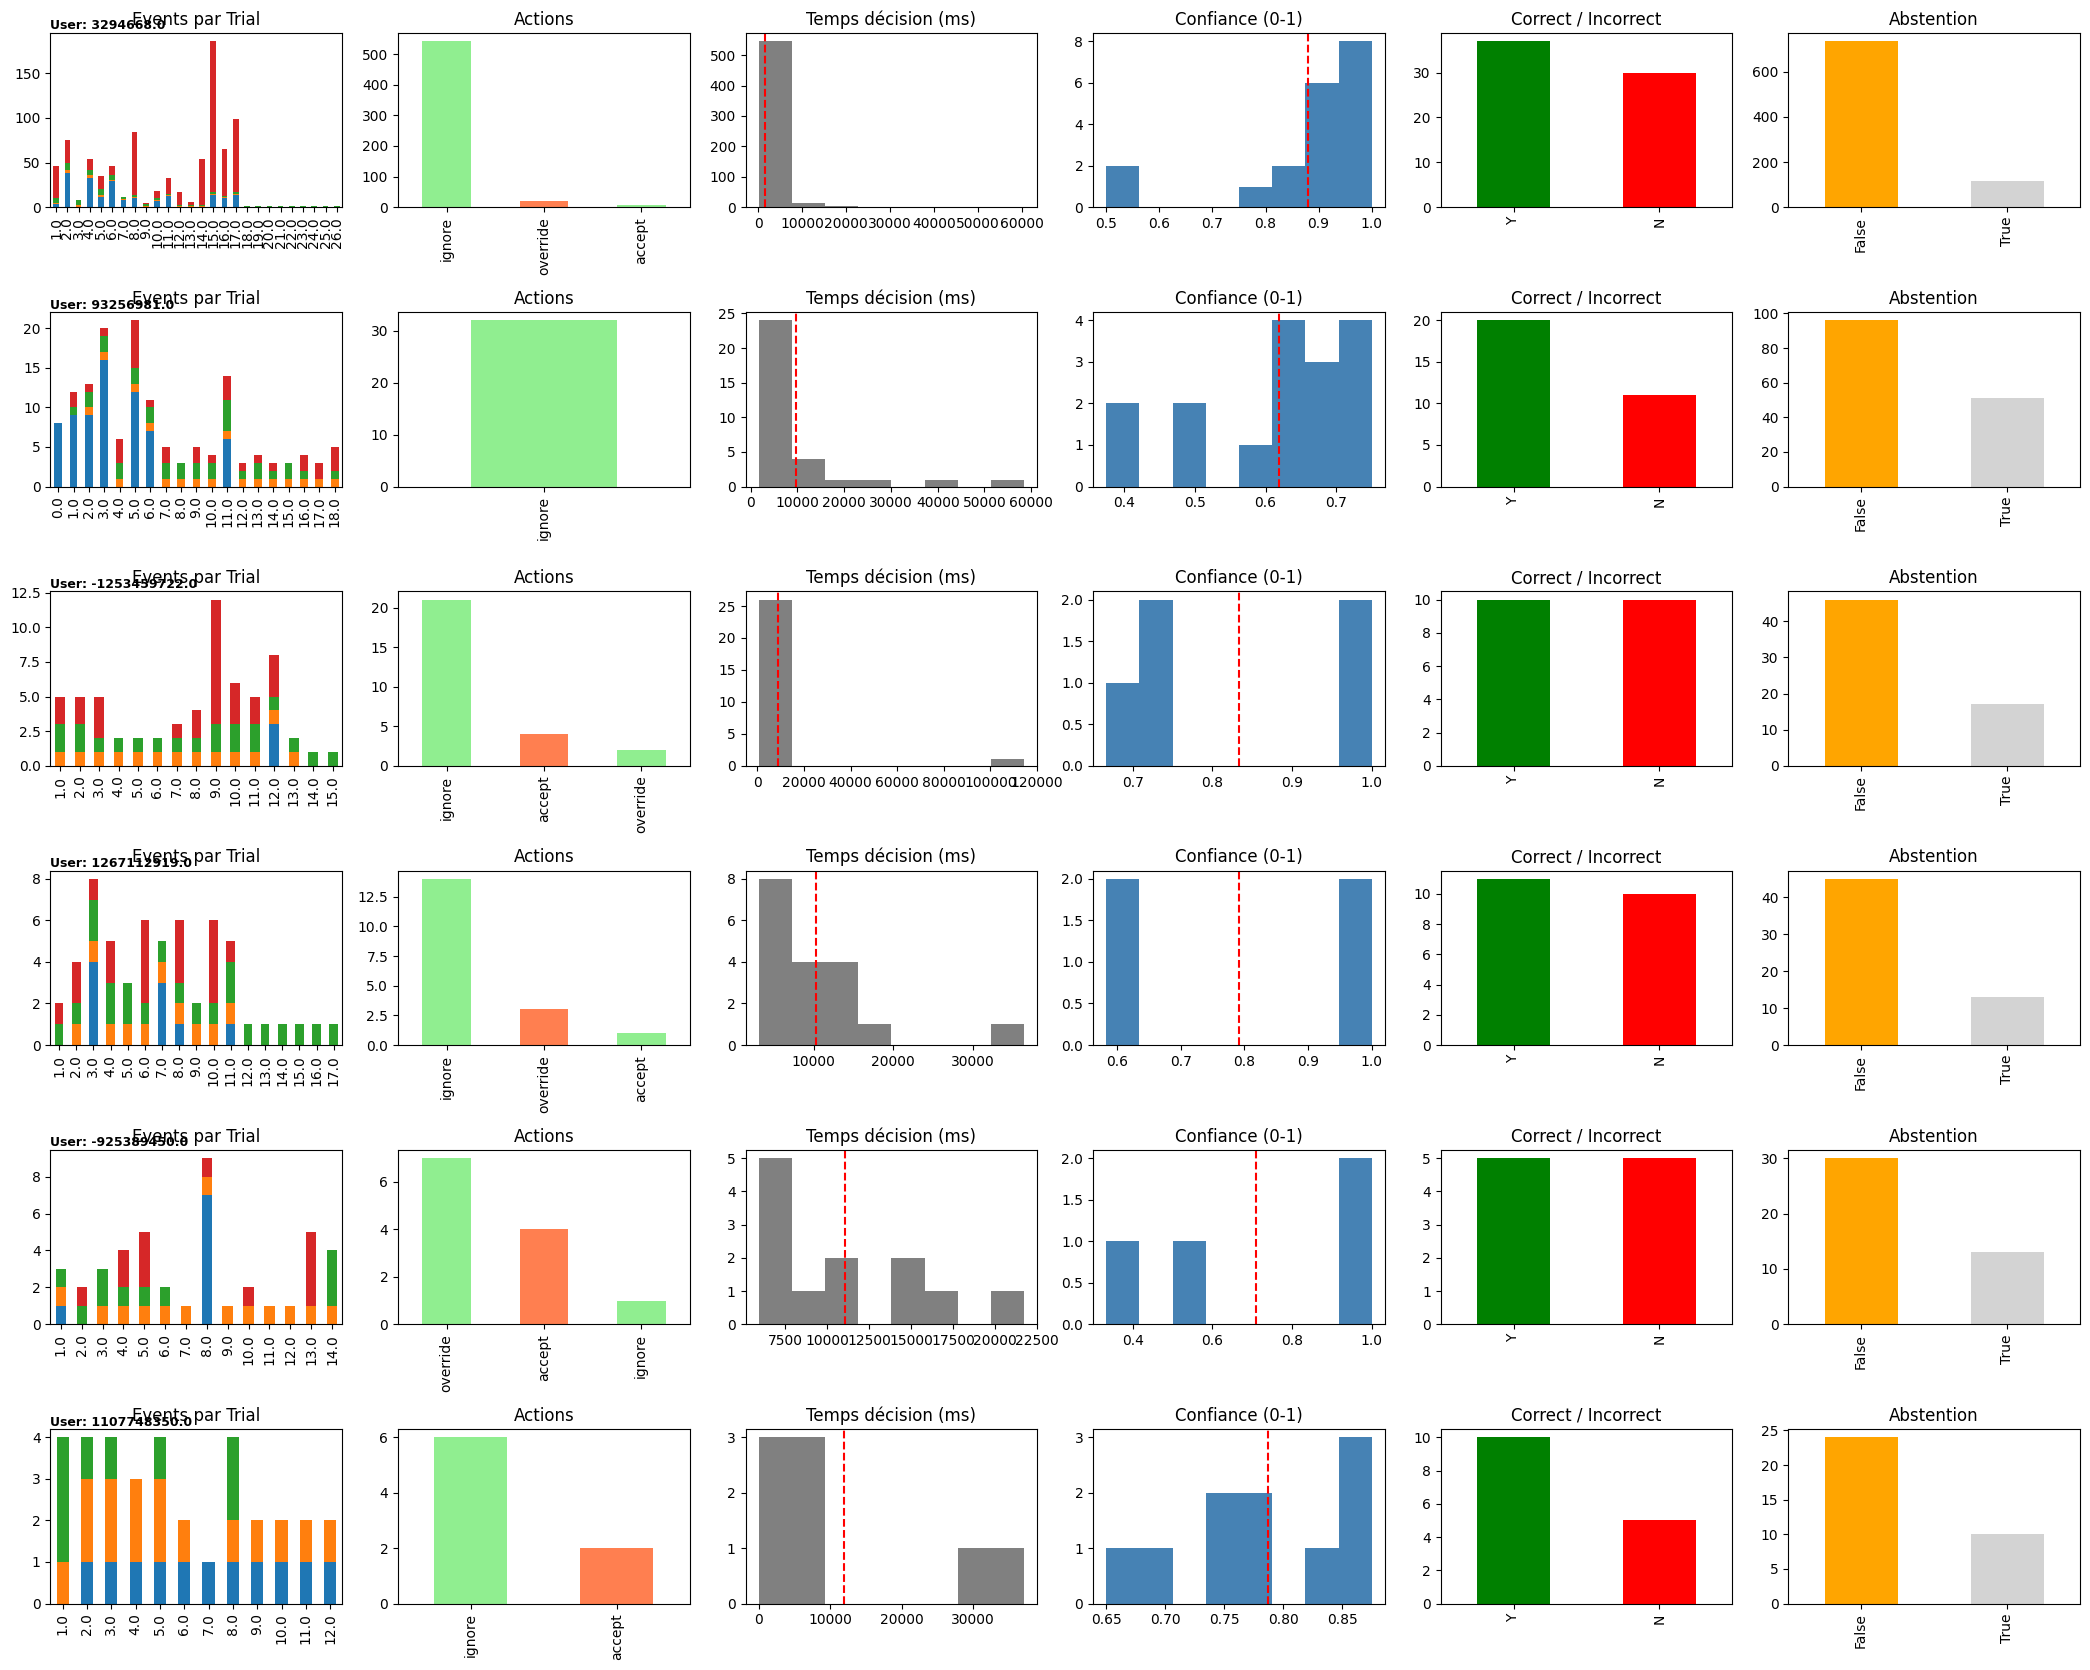

Saved grid image: user_graphs/all_users_grid_top6.png


In [ ]:
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

MAX_GRID_USERS = 10
os.makedirs('user_graphs', exist_ok=True)

if 'df' not in globals():
    if datasets.get('combined') is not None:
        df = datasets['combined']
    else:
        raise RuntimeError('Aucun DataFrame global trouvé. Exécutez dabord la cellule de construction de datasets.')

users_sorted = df['session_id'].value_counts().head(MAX_GRID_USERS).index.tolist() if 'session_id' in df.columns else []
num_users = len(users_sorted)
if num_users == 0:
    print('Aucun utilisateur à afficher.')
else:
    cols = 6
    rows = num_users
    figsize = (cols * 3.5, max(4, rows * 2.8))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = np.expand_dims(axes, 0)

    for i, user in enumerate(users_sorted):
        sd = df[df['session_id'] == user].copy()
        user_actions = sd[sd.get('event_type') == 'user_action'] if 'event_type' in sd.columns else sd.iloc[0:0]
        submits = sd[sd.get('event_type') == 'submit'] if 'event_type' in sd.columns else sd.iloc[0:0]

        ax1 = axes[i, 0]
        try:
            trial_events = sd.groupby(['trial_id', 'event_type']).size().unstack(fill_value=0) if 'trial_id' in sd.columns and 'event_type' in sd.columns else None
            if trial_events is not None and not trial_events.empty:
                trial_events.plot(ax=ax1, kind='bar', stacked=True, legend=False)
                ax1.set_title('Events par Trial')
            else:
                ax1.text(0.5, 0.5, 'Pas dévénements', ha='center')
        except Exception:
            ax1.text(0.5, 0.5, 'Pas dévénements', ha='center')
        ax1.set_xlabel('')

        ax2 = axes[i, 1]
        if len(user_actions) > 0 and 'human_action' in user_actions.columns:
            counts = user_actions['human_action'].value_counts()
            counts.plot(kind='bar', ax=ax2, color=['lightgreen', 'coral'])
            ax2.set_title('Actions')
        else:
            ax2.text(0.5,0.5,'Pas dactions', ha='center')
        ax2.set_xlabel('')

        ax3 = axes[i, 2]
        if len(user_actions) > 0 and 'decision_time_ms' in user_actions.columns and not user_actions['decision_time_ms'].isna().all():
            ax3.hist(user_actions['decision_time_ms'].dropna(), bins=8, color='gray')
            ax3.axvline(user_actions['decision_time_ms'].mean(), color='red', linestyle='--')
            ax3.set_title('Temps décision (ms)')
        else:
            ax3.text(0.5,0.5,'N/A', ha='center')
        ax3.set_xlabel('')

        ax4 = axes[i, 3]
        if len(submits) > 0 and 'user_confidence' in submits.columns and not submits['user_confidence'].isna().all():
            ax4.hist(submits['user_confidence'].dropna(), bins=8, color='steelblue')
            ax4.axvline(submits['user_confidence'].mean(), color='red', linestyle='--')
            ax4.set_title('Confiance (0-1)')
        else:
            ax4.text(0.5,0.5,'N/A', ha='center')
        ax4.set_xlabel('')

        ax5 = axes[i, 4]
        if len(submits) > 0 and 'correct' in submits.columns:
            submits['correct'].value_counts().reindex(['Y','N']).fillna(0).plot(kind='bar', ax=ax5, color=['green','red'])
            ax5.set_title('Correct / Incorrect')
        else:
            ax5.text(0.5,0.5,'N/A', ha='center')
        ax5.set_xlabel('')

        ax6 = axes[i, 5]
        if 'abstained' in sd.columns:
            try:
                sd['abstained'].value_counts().plot(kind='bar', ax=ax6, color=['orange','lightgray'])
                ax6.set_title('Abstention')
            except Exception:
                ax6.text(0.5,0.5,'N/A', ha='center')
        else:
            ax6.text(0.5,0.5,'N/A', ha='center')
        ax6.set_xlabel('')

        axes[i,0].annotate(f'User: {user}', xy=(0,1.02), xycoords='axes fraction', fontsize=9, fontweight='bold')

    plt.tight_layout()
    out_path = os.path.join('user_graphs', f'all_users_grid_top{num_users}.png')
    fig.savefig(out_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f'Saved grid image: {out_path}')


Données utilisées pour l'analyse (agrégation de tous les CSV): (1206, 18)

Nettoyage rapide OK!!!!!!!!!!!!!
Total événements: 1206
Trials (unique): 27
Conditions: H_only, H_plus_IA, AI_only, nan


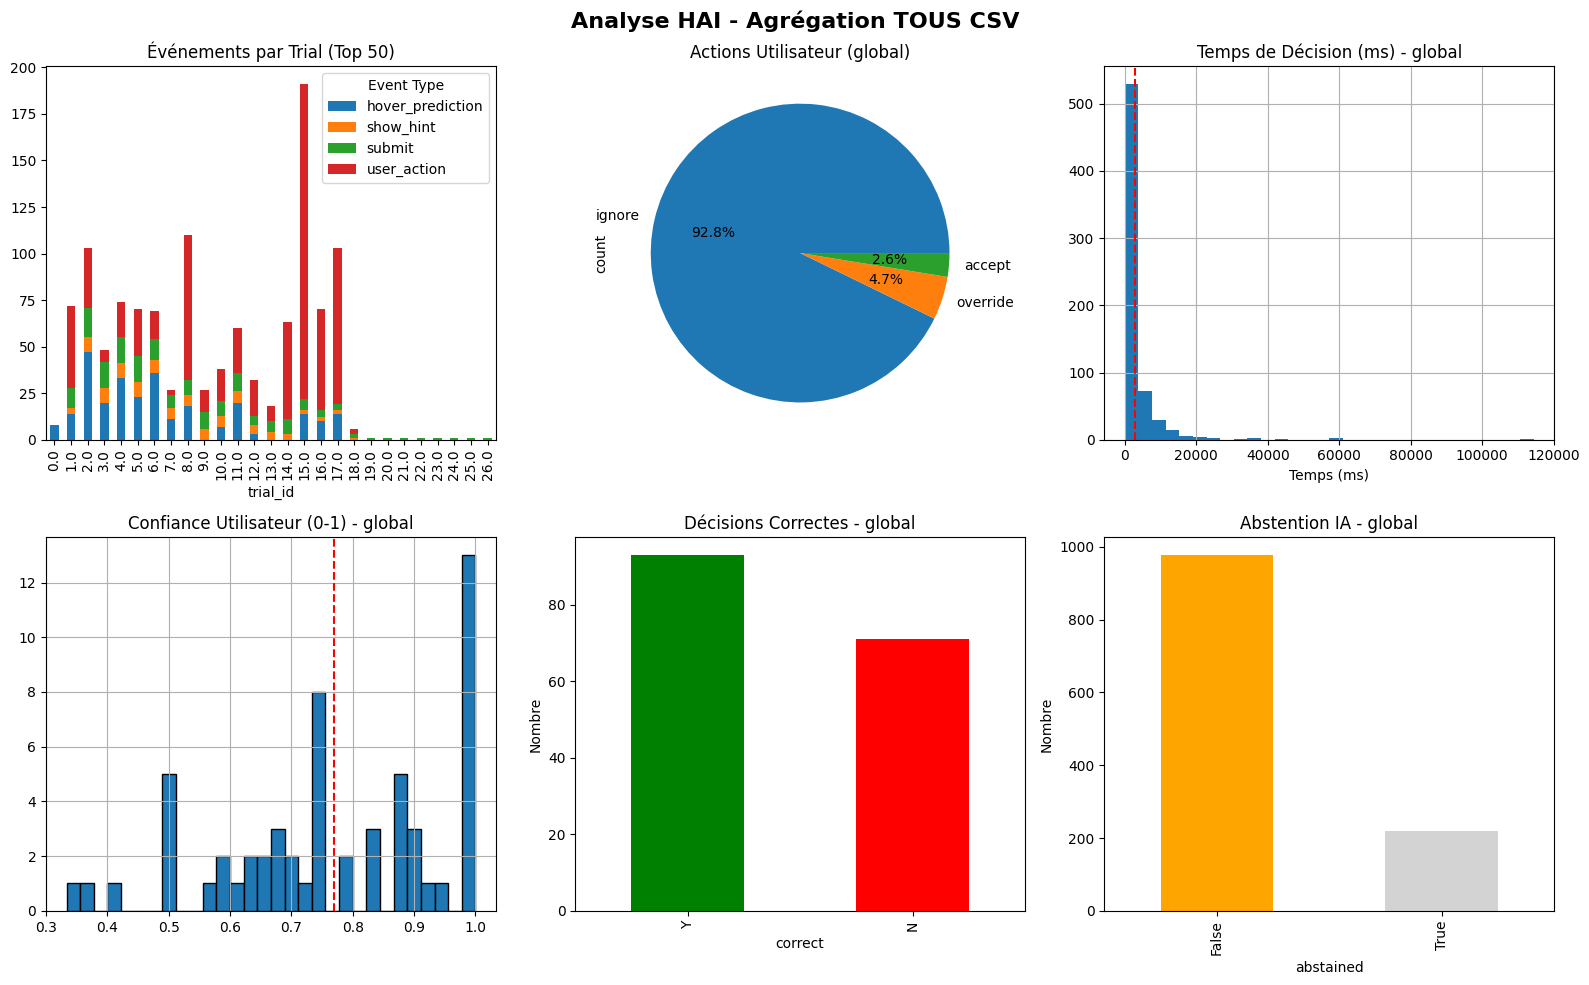


COMPARAISON H_only vs H+IA (TOUS CSV)
           human_action  decision_time_ms
condition                                
H_only             0.00           2337.34
H_plus_IA          0.35           8393.79
AI_only            0.00               NaN

UPLIFT & MÉTRIQUES AGGRÉGÉES
Taux succès H_only: 0.0%
Taux succès H+IA?: 72.4%
UPLIFT:+72.4%

Graphique sauvegardé: analyse_hai_allcsv.png


In [8]:
import matplotlib.pyplot as plt
import numpy as np

if datasets.get('combined') is not None:
    df = datasets['combined'].copy()
else:
    if datasets.get('by_file'):
        df = pd.concat(list(datasets['by_file'].values()), ignore_index=True, sort=False)
        print('datasets["combined"] absent → concaténation fallback réalisée')
    else:
        raise RuntimeError('Aucun dataframe disponible dans datasets pour tracer les graphiques')

print("Données utilisées pour l'analyse (agrégation de tous les CSV):", df.shape)

bool_cols = ['precondition_ok', 'abstained', 'fallback_used']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).map({'True': True, 'False': False, 'true': True, 'false': False, 'nan': None})

if 'decision_time_ms' in df.columns:
    df['decision_time_ms'] = pd.to_numeric(df['decision_time_ms'], errors='coerce')
if 'user_confidence' in df.columns:
    df['user_confidence'] = pd.to_numeric(df['user_confidence'], errors='coerce')
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

print('\nNettoyage rapide OK!!!!!!!!!!!!!')

total_events = len(df)
trials = df['trial_id'].nunique() if 'trial_id' in df.columns else np.nan
conditions = df['condition'].unique() if 'condition' in df.columns else []
print(f"Total événements: {total_events}")
print(f"Trials (unique): {trials}")
print(f"Conditions: {', '.join(map(str, conditions))}")

user_actions = df[df['event_type'] == 'user_action'].copy() if 'event_type' in df.columns else df.iloc[0:0]
submits = df[df['event_type'] == 'submit'].copy() if 'event_type' in df.columns else df.iloc[0:0]

ar = (user_actions['human_action'] == 'accept').mean() if len(user_actions) > 0 and 'human_action' in user_actions.columns else np.nan

dt_mean = user_actions['decision_time_ms'].mean() if len(user_actions) > 0 and 'decision_time_ms' in user_actions.columns else np.nan

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Analyse HAI - Agrégation TOUS CSV', fontsize=16, fontweight='bold')

ax1 = axes[0,0]
if 'trial_id' in df.columns and 'event_type' in df.columns:
    try:
        top_trials = df['trial_id'].value_counts().head(50).index
        trial_sample = df[df['trial_id'].isin(top_trials)]
        trial_events = trial_sample.groupby(['trial_id', 'event_type']).size().unstack(fill_value=0)
        if not trial_events.empty:
            trial_events.plot(ax=ax1, kind='bar', stacked=True)
            ax1.set_title('Événements par Trial (Top 50)')
            ax1.legend(title='Event Type')
        else:
            ax1.text(0.5, 0.5, "Pas d'événements", ha='center')
    except Exception:
        ax1.text(0.5, 0.5, "Pas d'événements", ha='center')
else:
    ax1.text(0.5, 0.5, "Pas de 'trial_id' ou 'event_type'", ha='center')

ax2 = axes[0,1]
if len(user_actions) > 0 and 'human_action' in user_actions.columns:
    user_actions['human_action'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
    ax2.set_title('Actions Utilisateur (global)')
else:
    ax2.text(0.5, 0.5, "Pas d'actions", ha='center')
    ax2.set_title('Actions Utilisateur')

ax3 = axes[0,2]
if len(user_actions) > 0 and 'decision_time_ms' in user_actions.columns and not user_actions['decision_time_ms'].isna().all():
    user_actions['decision_time_ms'].hist(bins=30, ax=ax3)
    ax3.axvline(user_actions['decision_time_ms'].mean(), color='red', linestyle='--')
    ax3.set_title('Temps de Décision (ms) - global')
    ax3.set_xlabel('Temps (ms)')
else:
    ax3.text(0.5, 0.5, "Pas de decision_time", ha='center')

ax4 = axes[1,0]
if len(submits) > 0 and 'user_confidence' in submits.columns and not submits['user_confidence'].isna().all():
    submits['user_confidence'].hist(bins=30, ax=ax4, edgecolor='black')
    ax4.axvline(submits['user_confidence'].mean(), color='red', linestyle='--')
    ax4.set_title('Confiance Utilisateur (0-1) - global')
else:
    ax4.text(0.5, 0.5, 'Pas de submits', ha='center')

ax5 = axes[1,1]
if len(submits) > 0 and 'correct' in submits.columns:
    submits['correct'].value_counts().plot(kind='bar', ax=ax5, color=['green', 'red'])
    ax5.set_title('Décisions Correctes - global')
    ax5.set_ylabel('Nombre')
else:
    ax5.text(0.5, 0.5, 'Pas de submits', ha='center')

ax6 = axes[1,2]
if 'abstained' in df.columns:
    try:
        abstentions = df['abstained'].value_counts()
        if len(abstentions) > 0:
            abstentions.plot(kind='bar', ax=ax6, color=['orange', 'lightgray'])
            ax6.set_title('Abstention IA - global')
            ax6.set_ylabel('Nombre')
        else:
            ax6.text(0.5, 0.5, "Pas d'abstention", ha='center')
    except Exception:
        ax6.text(0.5, 0.5, "Pas d'abstention", ha='center')
else:
    ax6.text(0.5, 0.5, "Pas d'abstention", ha='center')
plt.tight_layout()
plt.savefig('analyse_hai_allcsv.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("COMPARAISON H_only vs H+IA (TOUS CSV)") # pertinent dans notre cas
print("="*60)

if 'event_type' in df.columns:
    cond_stats = df[df['event_type'] == 'user_action'].groupby('condition').agg({
        'human_action': lambda x: (x=='accept').mean() if len(x)>0 else 0,
        'decision_time_ms': 'mean'
    }).round(2)
    print(cond_stats)
else:
    print('Pas de colonne event_type pour construire cond_stats')

print("\n" + "="*60)
print("UPLIFT & MÉTRIQUES AGGRÉGÉES")
print("="*60)

h_only_correct = df[(df['condition']=='H_only') & (df['event_type']=='submit')]['correct'].value_counts(normalize=True).get('Y', 0) if 'condition' in df.columns else 0
h_plus_correct = df[(df['condition']=='H_plus_IA') & (df['event_type']=='submit')]['correct'].value_counts(normalize=True).get('Y', 0) if 'condition' in df.columns else 0

uplift = h_plus_correct - h_only_correct
print(f"Taux succès H_only: {h_only_correct:.1%}")
print(f"Taux succès H+IA?: {h_plus_correct:.1%}")
print(f"UPLIFT:{uplift:+.1%}")

if datasets.get('combined') is None:
    datasets['combined'] = df
    print('datasets màj')

print('\nGraphique sauvegardé: analyse_hai_allcsv.png')


---
## H1 - Team Uplift (Performance Collaborative)

**Hypothèse** : La collaboration humain-IA surpasse les performances individuelles

**Métrique** : Team Uplift = (Perf_H+IA - max(Perf_H, Perf_IA)) / max(Perf_H, Perf_IA) ou comparaison valeurs brutes

**Critère** : Uplift > 0


MÉTRIQUES PAR UTILISATEUR - H_only
H_only submits trouvés: 0
H+IA submits trouvés:  58
AI_only submits: 106

Classement complet par utilisateur:
     session_id  h_only_trials  h_only_perf  h_plus_trials  h_plus_perf  ai_only_trials  ai_only_perf  reliance_hia  team_uplift  total_trials
    3294668.000             13        0.615             19        0.789              48         0.458         0.240        0.283            80
   93256981.000             16        0.667             16        0.812              15         0.467         0.000        0.219            47
-1253459722.000              8        0.750              5        0.800              15         0.400         0.667        0.067            28
 1267112919.000              7        0.286              4        0.500              17         0.529         0.250       -0.056            28
 1107748350.000              4        1.000             10        0.700               5         0.600         1.000       -0.300           

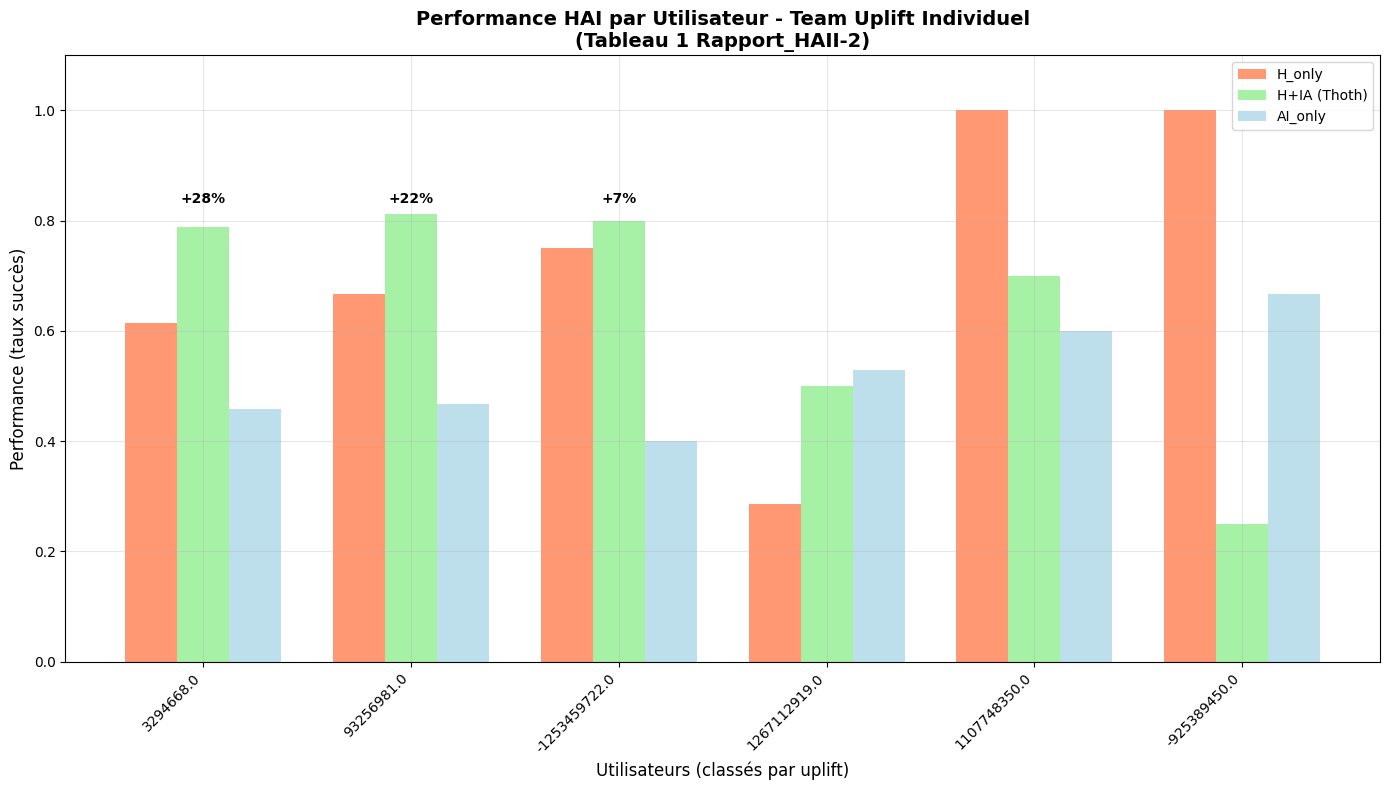


MÉTRIQUES PAR UTILISATEUR TERMINÉES!!!!


In [16]:
print("\n" + "="*80)
print("MÉTRIQUES PAR UTILISATEUR - H_only")
print("="*80)

df = datasets['combined']
if df is None:
    print("datasets combined non disponible")
else:
    h_only_submits = df[(df['event_type'] == 'submit') & (df['condition'] == 'H_only')]
    h_plus_submits = df[(df['event_type'] == 'submit') & (df['condition'] == 'H_plus_IA')]
    ai_only_submits = df[(df['event_type'] == 'submit') & (df['condition'] == 'AI_only')]

    print(f"H_only submits trouvés: {len(h_only_submits)}")
    print(f"H+IA submits trouvés:  {len(h_plus_submits)}")
    print(f"AI_only submits: {len(ai_only_submits)}")

    user_metrics = []

    for session_id in sorted(df['session_id'].dropna().unique()):
        session_data = df[df['session_id'] == session_id].copy()
        
        h_only_submit_trial_ids = set(session_data[
            (session_data['event_type'] == 'submit') & 
            (session_data['condition'] == 'H_only')]['trial_id'].dropna().unique())
        
        h_only_action_trial_ids = set(session_data[
            (session_data['event_type'] == 'user_action') & 
            (session_data['condition'] == 'H_only')]['trial_id'].dropna().unique())

        h_only_trial_ids = h_only_submit_trial_ids.union(h_only_action_trial_ids)
        h_only_trials = len(h_only_trial_ids)

        h_only_correct_list = []
        for tid in h_only_trial_ids:
            submit = session_data[(session_data['event_type'] == 'submit') & (session_data['trial_id'] == tid)]
            if len(submit) > 0 and 'correct' in submit.columns:
                h_only_correct_list.append(submit['correct'].iloc[0] == 'Y')
        
        h_only_perf = np.mean(h_only_correct_list) if h_only_correct_list else 0.0

        user_h_plus = session_data[(session_data['event_type'] == 'submit') & (session_data['condition'] == 'H_plus_IA')]
        h_plus_perf = (user_h_plus['correct'] == 'Y').mean() if len(user_h_plus) > 0 else 0.0
        h_plus_trials = len(user_h_plus)

        user_ai_only = session_data[(session_data['event_type'] == 'submit') & (session_data['condition'] == 'AI_only')]
        ai_only_perf = (user_ai_only['correct'] == 'Y').mean() if len(user_ai_only) > 0 else 0.0
        ai_only_trials = len(user_ai_only)

        baseline = max(h_only_perf, ai_only_perf)
        team_uplift = (h_plus_perf - baseline) / baseline if baseline > 0 else 0

        user_actions_hia = session_data[(session_data['event_type'] == 'user_action') & (session_data['condition'] == 'H_plus_IA')]
        reliance = (user_actions_hia['human_action'] == 'accept').mean() if len(user_actions_hia) > 0 else 0
        
        user_metrics.append({
            'session_id': session_id,
            'h_only_trials': h_only_trials,
            'h_only_perf': h_only_perf,
            'h_plus_trials': h_plus_trials,
            'h_plus_perf': h_plus_perf,
            'ai_only_trials': ai_only_trials,
            'ai_only_perf': ai_only_perf,
            'reliance_hia': reliance,
            'team_uplift': team_uplift,
            'total_trials': h_only_trials + h_plus_trials + ai_only_trials})

    user_df = pd.DataFrame(user_metrics).round(3)
    user_df = user_df.sort_values('team_uplift', ascending=False)

    datasets['user_metrics'] = user_df

    print("\nClassement complet par utilisateur:")
    print(user_df.to_string(index=False, float_format='%.3f'))

    perf_h_only_avg = h_only_submits['correct'].eq('Y').mean() if len(h_only_submits) > 0 else 0
    perf_h_plus_avg = h_plus_submits['correct'].eq('Y').mean() if len(h_plus_submits) > 0 else 0
    perf_ai_only_avg = ai_only_submits['correct'].eq('Y').mean() if len(ai_only_submits) > 0 else 0

    print(f"\nVÉRIFICATION GLOBALE:")
    print(f"H_only (submits):  {perf_h_only_avg:.1%} ({len(h_only_submits)})")
    print(f"H+IA: {perf_h_plus_avg:.1%} ({len(h_plus_submits)})") 
    print(f"AI_only: {perf_ai_only_avg:.1%} ({len(ai_only_submits)})")
    print(f"Team Uplift moyen:  {user_df['team_uplift'].mean():.1%}")

    print(f"\nTOP 3 Uplift: {user_df.head(3)['session_id'].tolist()}")
    print(f"BOTTOM 3: {user_df.tail(3)['session_id'].tolist()}")

    pivot_perf = user_df.pivot_table(
        index='session_id',
        values=['h_only_perf', 'h_plus_perf', 'ai_only_perf', 'team_uplift'],
        aggfunc='mean').round(3)

    print(f"\nTABLEAU PIVOTÉ (Excel):")
    print(pivot_perf.to_string())

    user_df.to_csv('metriques_utilisateurs_complet.csv', index=False)
    pivot_perf.to_csv('tableau_utilisateurs_pivot.csv', index=False)
    print(f"\nEXPORTÉS + datasets user_metrics:")
    print("- metriques_utilisateurs_complet.csv")
    print("- tableau_utilisateurs_pivot.csv")

    import matplotlib.pyplot as plt
    plt.figure(figsize=(14, 8))
    top_10_users = user_df.head(10)

    x = np.arange(len(top_10_users))
    width = 0.25

    plt.bar(x - width, top_10_users['h_only_perf'], width, label='H_only', alpha=0.8, color='coral')
    plt.bar(x, top_10_users['h_plus_perf'], width, label='H+IA (Thoth)', alpha=0.8, color='lightgreen')
    plt.bar(x + width, top_10_users['ai_only_perf'], width, label='AI_only', alpha=0.8, color='lightblue')

    for i, uplift in enumerate(top_10_users['team_uplift']):
        if uplift > 0:
            plt.text(i, max(top_10_users['h_plus_perf'].max(), 0.1) + 0.02, 
                    f"+{uplift:.0%}", ha='center', fontweight='bold')

    plt.xlabel('Utilisateurs (classés par uplift)', fontsize=12)
    plt.ylabel('Performance (taux succès)', fontsize=12)
    plt.title('Performance HAI par Utilisateur - Team Uplift Individuel\n(Tableau 1 Rapport_HAII-2)', fontsize=14, fontweight='bold')
    plt.xticks(x, top_10_users['session_id'], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.savefig('performance_par_utilisateur.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nMÉTRIQUES PAR UTILISATEUR TERMINÉES!!!!")


---
## H2 - Calibration Utilisateur

**Hypothèse** : La confiance utilisateur est corrélée avec la justesse  

**Métrique** : Corrélation de Pearson entre user_confidence et correct_bool  

**Critère** : r > 0.5 et p < 0.05

Test H2 - Calibration Confiance x Correct
RÉSULTATS H2 - CALIBRATION (MULTI-SESSIONS)
Sessions analysées : 6
N observations  : 58
Corrélation Pearson : r = 0.217
P-value   : p = 0.1023
IC 95%  : [-0.044, 0.450]

H2 REJETÉE


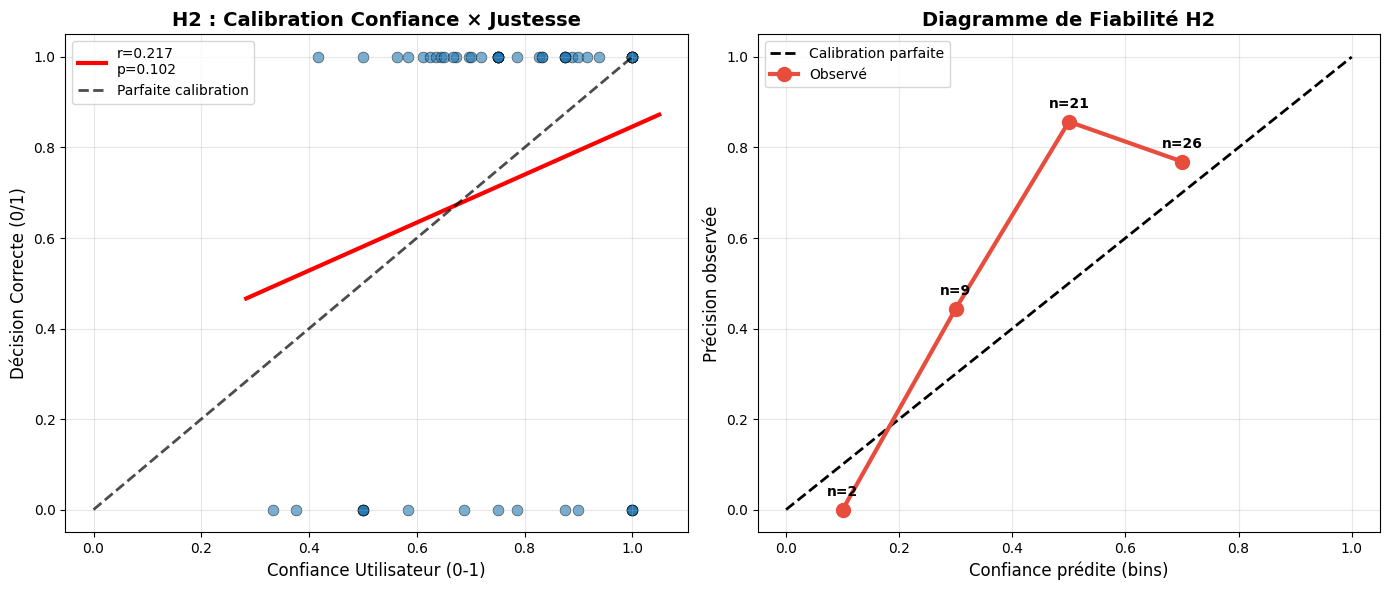


Figure sauvegardée : h2_calibration_datasets.png
6 sessions, 58 observations


In [18]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def test_calibration(datasets):
    """Teste calibration user_confidence x correct."""

    df = datasets['combined']
    if df is None:
        print("datasets combined erreur")
        return None, None

    submits = df[(df['event_type'] == 'submit')].copy()
    if len(submits) == 0:
        print("Aucun submit trouvé dans datasets combined")
        return None, None
        
    submits['correct_bool'] = (submits['correct'] == 'Y').astype(float)
    calib_data = submits[
        (submits['user_confidence'].notna()) &
        (submits['correct_bool'].notna())][['user_confidence', 'correct_bool']].copy()

    if len(calib_data) < 3:
        print(f"Données insuffisantes pour H2: {len(calib_data)} points")
        return None, None

    r, p_value = pearsonr(calib_data['user_confidence'], calib_data['correct_bool'])

    z = np.arctanh(r)
    se = 1 / np.sqrt(len(calib_data) - 3)
    ci_low = np.tanh(z - 1.96 * se)
    ci_high = np.tanh(z + 1.96 * se)

    results = {
        'r': r,
        'p_value': p_value,
        'n': len(calib_data),
        'n_sessions': submits['session_id'].nunique(),
        'ci_95': (ci_low, ci_high)
    }

    print("RÉSULTATS H2 - CALIBRATION (MULTI-SESSIONS)")
    print("="*70)
    print(f"Sessions analysées : {results['n_sessions']}")
    print(f"N observations  : {results['n']}")
    print(f"Corrélation Pearson : r = {r:.3f}")
    print(f"P-value   : p = {p_value:.4f}")
    print(f"IC 95%  : [{ci_low:.3f}, {ci_high:.3f}]")
    print(f"\nH2 {'VALIDÉE' if (r > 0.5 and p_value < 0.05) else 'REJETÉE'}")

    return results, calib_data

print("Test H2 - Calibration Confiance x Correct")
calib_results, calib_data = test_calibration(datasets)

if calib_results is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.scatter(calib_data['user_confidence'], calib_data['correct_bool'], 
                alpha=0.6, s=60, edgecolors='black', linewidth=0.5)

    z = np.polyfit(calib_data['user_confidence'], calib_data['correct_bool'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(calib_data['user_confidence'].min()-0.05, calib_data['user_confidence'].max()+0.05, 100)
    ax1.plot(x_line, p(x_line), "r-", linewidth=3, label=f'r={calib_results["r"]:.3f}\np={calib_results["p_value"]:.3f}')

    ax1.plot([0,1], [0,1], 'k--', alpha=0.7, linewidth=2, label='Parfaite calibration')
    
    ax1.set_xlabel('Confiance Utilisateur (0-1)', fontsize=12)
    ax1.set_ylabel('Décision Correcte (0/1)', fontsize=12)
    ax1.set_title('H2 : Calibration Confiance × Justesse', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)

    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    calib_data['conf_bin'] = pd.cut(calib_data['user_confidence'], bins=bins)
    reliability = calib_data.groupby('conf_bin', observed=True).agg({
        'correct_bool': ['mean', 'count']
    }).round(3)

    bin_centers = [0.1, 0.3, 0.5, 0.7, 0.9]
    actual_accuracy = reliability['correct_bool']['mean'].values
    counts = reliability['correct_bool']['count'].values

    ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Calibration parfaite')

    ax2.plot(bin_centers[:len(actual_accuracy)], actual_accuracy, 
             'o-', linewidth=3, markersize=10, color='#e74c3c', label='Observé')

    for i, (x, y, n) in enumerate(zip(bin_centers[:len(actual_accuracy)], 
                                       actual_accuracy, counts)):
        ax2.text(x, y+0.03, f'n={int(n)}', ha='center', fontsize=10, fontweight='bold')

    ax2.set_xlabel('Confiance prédite (bins)', fontsize=12)
    ax2.set_ylabel('Précision observée', fontsize=12)
    ax2.set_title('Diagramme de Fiabilité H2', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.set_xlim(-0.05, 1.05)
    ax2.set_ylim(-0.05, 1.05)

    plt.tight_layout()
    plt.savefig('h2_calibration_datasets.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nFigure sauvegardée : h2_calibration_datasets.png")
    print(f"{calib_results['n_sessions']} sessions, {calib_results['n']} observations")
else:
    print("Pas assez de données pour test H2")


---
## H3 - Abstention Adaptative vs Volatilité

**Hypothèse** : Taux abstention corrélé avec volatilité fonds  

**Métrique** : Corrélation de Spearman  

**Critère** : ρ > 0.6 et p < 0.05

Test H3 - Abstention vs Volatilité
RÉSULTATS H3 - ABSTENTION VS. VOLATILITÉ
Fonds analysés : 5
Fonds: Amazon, Apple, Bnp, Netflix, Tesla
Corrélation Spearman: ρ = 0.975
P-value : p = 0.0048

H3 VALIDEE


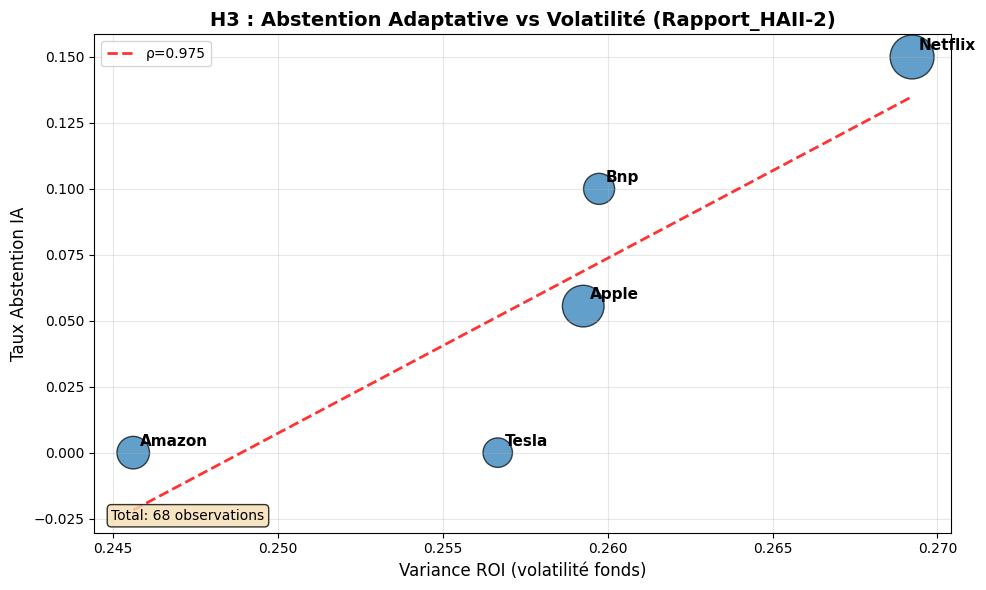


Figure H3 sauvegardée : h3_abstention.png
5 fonds analysés


In [19]:
import re
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

def test_abstention_volatility(datasets):
    """Teste corrélation abstention × volatilité fonds."""
    
    df = datasets['combined']
    if df is None:
        print("datasets combined non disponible")
        return None, None

    def extract_fund_name(note):
        if pd.isna(note):
            return None
        note_str = str(note).lower()
        match = re.search(r'sur\s+(\w+)', note_str)
        if not match:
            match = re.search(r'recommendation[:\s]+(\w+)', note_str)
        return match.group(1).title() if match else None

    df = df.copy()
    df['fund_name'] = df['notes'].apply(extract_fund_name)

    required_cols = ['condition', 'event_type', 'abstained']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Colonnes manquantes: {missing_cols}")
        return None, None

    ai_only = df[(df['condition'] == 'AI_only') & (df['fund_name'].notna())].copy()
    
    if 'correct' in ai_only.columns:
        ai_only['roi_proxy'] = (ai_only['correct'] == 'Y').astype(float)
        roi_col = 'roi_proxy'
    elif 'roi_extracted' in ai_only.columns:
        roi_col = 'roi_extracted'
    else:
        print("Pas de métrique ROI")
        return None, None

    fund_variance = ai_only[ai_only[roi_col].notna()].groupby('fund_name')[roi_col].agg(['var', 'count'])

    hints = df[(df['event_type'] == 'show_hint') & (df['fund_name'].notna())]
    abstention_by_fund = hints.groupby('fund_name')['abstained'].agg(['mean', 'count'])

    analysis_df = fund_variance.join(abstention_by_fund, how='inner', lsuffix='_roi', rsuffix='_abs')
    analysis_df = analysis_df[analysis_df['count_roi'] >= 2]

    if len(analysis_df) < 2:
        print(f"Fonds insuffisants: {len(analysis_df)}")
        return None, None

    rho, p_value = spearmanr(analysis_df['var'], analysis_df['mean'])

    results = {
        'rho': rho,
        'p_value': p_value,
        'n_funds': len(analysis_df),
        'funds_analyzed': analysis_df.index.tolist()
    }

    print("RÉSULTATS H3 - ABSTENTION VS. VOLATILITÉ")
    print("="*70)
    print(f"Fonds analysés : {results['n_funds']}")
    print(f"Fonds: {', '.join(results['funds_analyzed'])}")
    print(f"Corrélation Spearman: ρ = {rho:.3f}")
    print(f"P-value : p = {p_value:.4f}")
    print(f"\nH3 {'VALIDEE' if (rho > 0.6 and p_value < 0.05) else 'REJETEE'}")

    return results, analysis_df

print("Test H3 - Abstention vs Volatilité")
abstention_results, abstention_df = test_abstention_volatility(datasets)
if abstention_results is not None and len(abstention_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))

    x_clean = pd.to_numeric(abstention_df['var'], errors='coerce').fillna(0).values
    y_clean = pd.to_numeric(abstention_df['mean'], errors='coerce').fillna(0).values
    sizes = pd.to_numeric(abstention_df['count_abs'], errors='coerce').fillna(1) * 50

    scatter = ax.scatter(x_clean, y_clean, s=sizes, alpha=0.7, edgecolors='black', linewidth=1)

    for i, fund_name in enumerate(abstention_df.index):
        ax.annotate(fund_name, (x_clean[i], y_clean[i]), xytext=(5, 5), textcoords='offset points', fontsize=11, fontweight='bold', ha='left')

    if len(x_clean) >= 2:
        if np.all(np.isfinite(x_clean)) and np.all(np.isfinite(y_clean)):
            try:
                z = np.polyfit(x_clean, y_clean, 1)
                p = np.poly1d(z)
                x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
                ax.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8, label=f'ρ={abstention_results["rho"]:.3f}')
            except Exception as e:
                print(f"Tendance ignorée: {e}")
        else:
            print("Données non-numériques -> pas de ligne de tendance")

    ax.set_xlabel('Variance ROI (volatilité fonds)', fontsize=12)
    ax.set_ylabel('Taux Abstention IA', fontsize=12)
    ax.set_title('H3 : Abstention Adaptative vs Volatilité (Rapport_HAII-2)', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

    total_obs = abstention_df['count_abs'].sum()
    ax.text(0.02, 0.02, f'Total: {int(total_obs)} observations', transform=ax.transAxes, fontsize=10, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.savefig('h3_abstention.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nFigure H3 sauvegardée : h3_abstention.png")
    print(f"{abstention_results['n_funds']} fonds analysés")
else:
    print("Pas assez de données H3 aaaaaa")


---
## H4 - Convergence Feedback Loop

**Hypothèse** : Feedback multiplier stable après 10 trials  

**Métrique** : Rolling std du feedback multiplier  

**Critère** : σ < 0.1 après trial 10

Test H4 - Convergence Feedback Multiplier
RÉSULTATS H4 - CONVERGENCE FEEDBACK (MULTI-SESSIONS)
Sessions analysées : 6
Nombre trials : 58
Écart-type final : 0.2928
Convergence atteinte au trial 10.0
H4 VALIDÉE (boucle adaptative fonctionne)


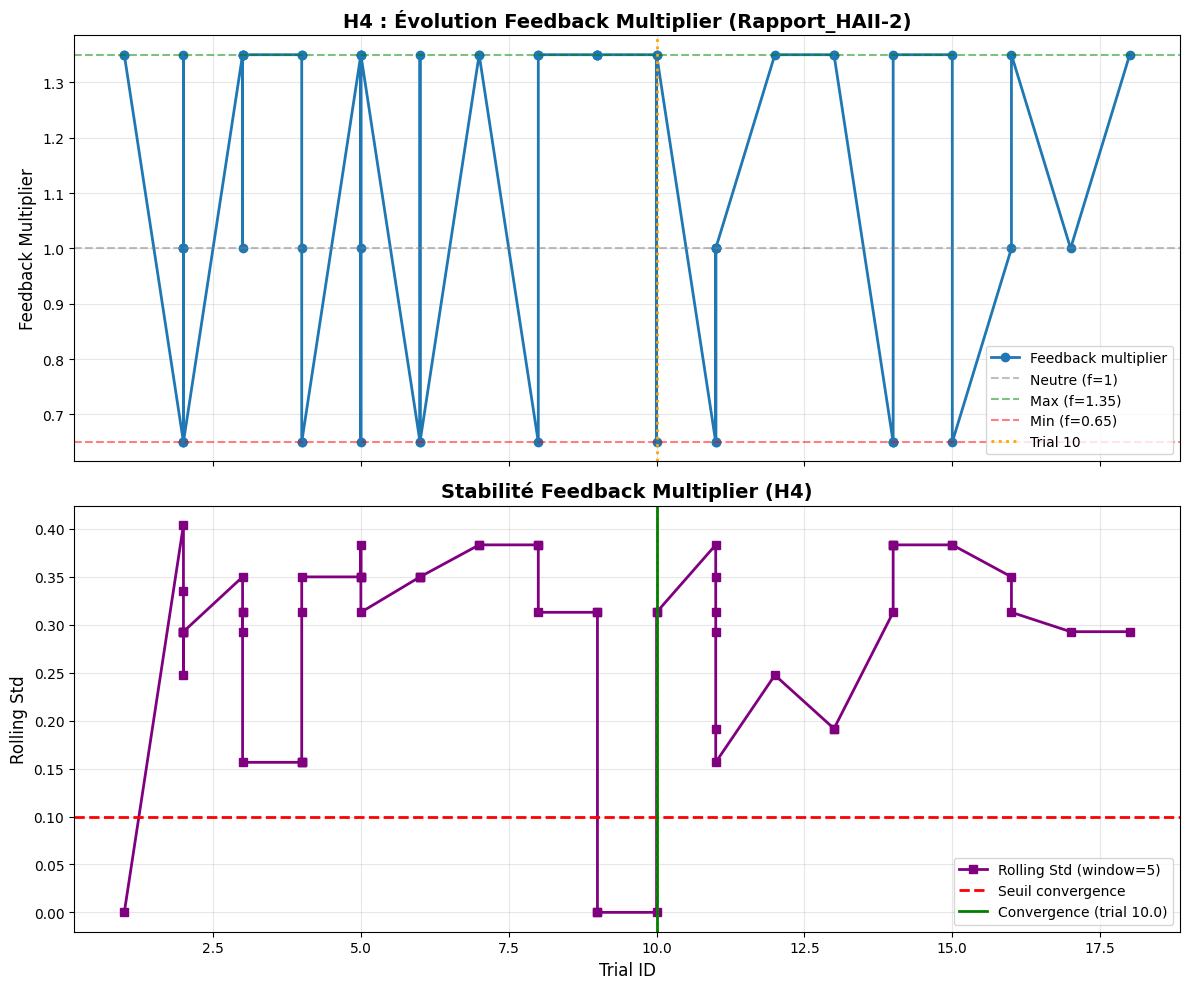


Figure sauvegardée : h4_feedback_convergence_datasets.png
6 sessions, 58 trials analysés


In [26]:
def test_feedback_convergence(datasets): # todo à revoir peut etre sur la stabilisation
    """Teste convergence feedback multiplier"""
    
    df = datasets['combined']
    if df is None:
        print("datasets['combined'] non disponible")
        return None, None

    def extract_feedback_score(note):
        if pd.isna(note):
            return np.nan
        note_lower = str(note).lower()
        if 'helpful' in note_lower and 'not' not in note_lower and 'somewhat' not in note_lower:
            return 1
        elif 'somewhat' in note_lower:
            return 0
        elif 'not' in note_lower or 'did not' in note_lower:
            return -1
        return np.nan

    feedback_data = df[(df['event_type'] == 'submit') &
        (df['condition'] == 'H_plus_IA')].copy()

    if len(feedback_data) == 0:
        print("Aucun submit H_plus_IA trouvé dans datasets['combined']")
        return None, None

    feedback_data['raw_score'] = feedback_data['notes'].apply(extract_feedback_score)
    feedback_data = feedback_data[feedback_data['raw_score'].notna()].sort_values('trial_id')

    if len(feedback_data) < 10:
        print(f"Moins de 10 trials avec feedback: {len(feedback_data)} trouvés")
        return None, None

    feedback_data['feedback_multiplier'] = 1 + 0.35 * feedback_data['raw_score']
    feedback_data['rolling_std'] = feedback_data['feedback_multiplier'].rolling(window=5, min_periods=1).std()

    convergence_trials = feedback_data[(feedback_data['trial_id'] >= 10) & 
        (feedback_data['rolling_std'] < 0.1)]

    converged = len(convergence_trials) > 0
    convergence_point = convergence_trials.iloc[0]['trial_id'] if converged else None

    results = {'converged': converged,
        'convergence_trial': convergence_point,
        'final_std': feedback_data['rolling_std'].iloc[-1],
        'n_trials': len(feedback_data),
        'n_sessions': feedback_data['session_id'].nunique()}

    print("RÉSULTATS H4 - CONVERGENCE FEEDBACK (MULTI-SESSIONS)")
    print("="*70)
    print(f"Sessions analysées : {results['n_sessions']}")
    print(f"Nombre trials : {results['n_trials']}")
    print(f"Écart-type final : {results['final_std']:.4f}")
    
    if converged:
        print(f"Convergence atteinte au trial {convergence_point}")
        print(f"H4 VALIDÉE (boucle adaptative fonctionne)")
    else:
        print(f"Pas de convergence (σ < 0.1) après trial 10")
        print(f"H4: Adaptation lente ou feedback insuffisant")

    return results, feedback_data

print("Test H4 - Convergence Feedback Multiplier")
feedback_results, feedback_data = test_feedback_convergence(datasets)

if feedback_results is not None:
    import matplotlib.pyplot as plt ## gg les mecs
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    ax1.plot(feedback_data['trial_id'], feedback_data['feedback_multiplier'], 'o-', linewidth=2, markersize=6, label='Feedback multiplier')
    ax1.axhline(1, color='gray', linestyle='--', alpha=0.5, label='Neutre (f=1)')
    ax1.axhline(1.35, color='green', linestyle='--', alpha=0.5, label='Max (f=1.35)')
    ax1.axhline(0.65, color='red', linestyle='--', alpha=0.5, label='Min (f=0.65)')
    ax1.axvline(10, color='orange', linestyle=':', linewidth=2, label='Trial 10')
    ax1.set_ylabel('Feedback Multiplier', fontsize=12)
    ax1.set_title('H4 : Évolution Feedback Multiplier (Rapport_HAII-2)', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(alpha=0.3)

    ax2.plot(feedback_data['trial_id'], feedback_data['rolling_std'], 's-', linewidth=2, markersize=6, color='purple', label='Rolling Std (window=5)')
    ax2.axhline(0.1, color='red', linestyle='--', linewidth=2, label='Seuil convergence')
    ax2.axvline(10, color='orange', linestyle=':', linewidth=2)

    if feedback_results['converged']:
        ax2.axvline(feedback_results['convergence_trial'], color='green', linestyle='-', linewidth=2, label=f'Convergence (trial {feedback_results["convergence_trial"]})')

    ax2.set_xlabel('Trial ID', fontsize=12)
    ax2.set_ylabel('Rolling Std', fontsize=12)
    ax2.set_title('Stabilité Feedback Multiplier (H4)', fontsize=14, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('h4_feedback_convergence_datasets.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nFigure sauvegardée : h4_feedback_convergence_datasets.png")
    print(f"{feedback_results['n_sessions']} sessions, {feedback_results['n_trials']} trials analysés")
else:
    print("Pas assez de données H_plus_IA pour test H4")


H4 - ÉVOLUTION CONFIANCE (meilleure session H+ IA)


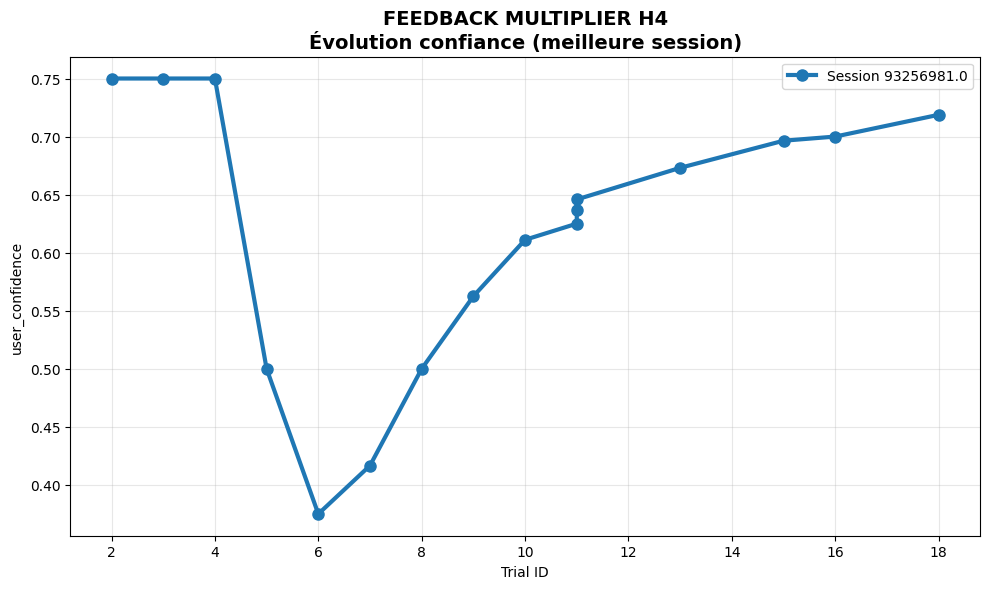

H4 : Session 93256981.0 (16 submits)
Performance: 81.2%
H4_evolution_confiance.png sauvegardé


In [28]:
df = datasets['combined']
print("H4 - ÉVOLUTION CONFIANCE (meilleure session H+ IA)")

submit_hia = df[(df['event_type'] == 'submit') & (df['condition'] == 'H_plus_IA')]
if len(submit_hia) > 0:
    session_perf = submit_hia.groupby('session_id')['correct'].apply(lambda x: (x=='Y').mean())
    top_session = session_perf.idxmax()
    top_data = df[(df['session_id'] == top_session) & (df['event_type'] == 'submit') & (df['condition'] == 'H_plus_IA')]
 
    plt.figure(figsize=(10, 6))
    plt.plot(top_data['trial_id'], top_data['user_confidence'], 'o-', linewidth=3, markersize=8, label=f"Session {top_session}")
    plt.title('FEEDBACK MULTIPLIER H4\nÉvolution confiance (meilleure session)', fontsize=14, fontweight='bold')
    plt.xlabel('Trial ID')
    plt.ylabel('user_confidence')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('H4_evolution_confiance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"H4 : Session {top_session} ({len(top_data)} submits)")
    print(f"Performance: {session_perf[top_session]:.1%}") # bonne version feedback
else:
    print("Pas de H+IA submits pour H4")

print("H4_evolution_confiance.png sauvegardé")


---
## H5 - Reliance Appropriée

**Hypothèse** : Taux acceptation décroît avec incertitude IA  

**Métrique** : Taux acceptation(low) > medium > high

**Critère** : Chi² test p < 0.05 ET ordre décroissant

H5 - RELIANCE HUMAINE VS INCERTITUDE IA


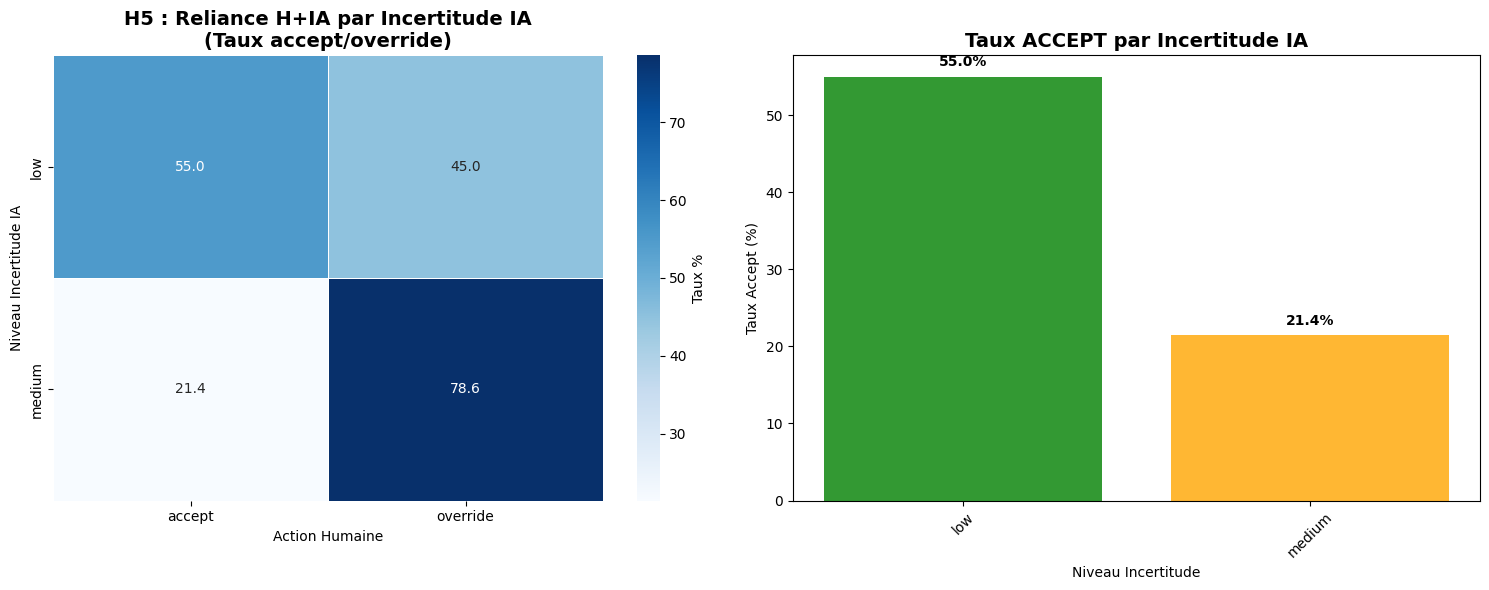

H5 : 48 actions H+IA analysées

Tableau croisé :
human_action    accept  override
ai_uncertainty                  
low               55.0      45.0
medium            21.4      78.6
Taux accept moyen: 38.2%


In [31]:
print("H5 - RELIANCE HUMAINE VS INCERTITUDE IA")

actions_hia = df[(df['event_type'] == 'user_action') & (df['condition'] == 'H_plus_IA')].copy()

unc_map = {'low': 0.2, 'medium': 0.5, 'mid': 0.5, 'high': 0.8, '': np.nan}
actions_hia['unc_num'] = actions_hia['ai_uncertainty'].map(unc_map)

ct = pd.crosstab(actions_hia['ai_uncertainty'], actions_hia['human_action'], normalize='index').fillna(0) * 100

fig = plt.figure(figsize=(15, 6))

ax1 = plt.subplot(1, 2, 1)
sns.heatmap(ct, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': 'Taux %'}, ax=ax1, linewidths=0.5)
ax1.set_title('H5 : Reliance H+IA par Incertitude IA\n(Taux accept/override)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Action Humaine')
ax1.set_ylabel('Niveau Incertitude IA')

ax2 = plt.subplot(1, 2, 2)
accept_rates = ct['accept'].sort_index() if 'accept' in ct.columns else pd.Series()
bars = ax2.bar(accept_rates.index, accept_rates.values, color=['green' if x>50 else 'orange' for x in accept_rates.values], alpha=0.8)
ax2.set_title('Taux ACCEPT par Incertitude IA', fontsize=14, fontweight='bold')
ax2.set_ylabel('Taux Accept (%)')
ax2.set_xlabel('Niveau Incertitude')
ax2.tick_params(axis='x', rotation=45)

for bar, rate in zip(bars, accept_rates.values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,  f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('H5_reliance_incertitude.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"H5 : {len(actions_hia)} actions H+IA analysées")
print("\nTableau croisé :")
print(ct.round(1))
if len(accept_rates) > 0:
    print(f"Taux accept moyen: {accept_rates.mean():.1f}%")


---
## Analyses supplémentaires

La section contient les temps de décisions et autres métriques supplémentaires discutées dans le rapport.

TEMPS DE DÉCISION + CORRÉLATIONS - Adapté datasets
TEMPS DE DÉCISION PAR CONDITION
           count         mean          std     min      25%     50%      75%  \
condition                                                                      
H_only     616.0  2337.342532  7093.232306     2.0   152.00   203.5  1768.00   
H_plus_IA   48.0  8393.791667  5989.329725  2598.0  4606.75  6994.0  9614.75   
AI_only      0.0          NaN          NaN     NaN      NaN     NaN      NaN   

                max  
condition            
H_only     114436.0  
H_plus_IA   36487.0  
AI_only         NaN  

Mann-Whitney U : U=2736.00, p=0.0000
 Différence significative


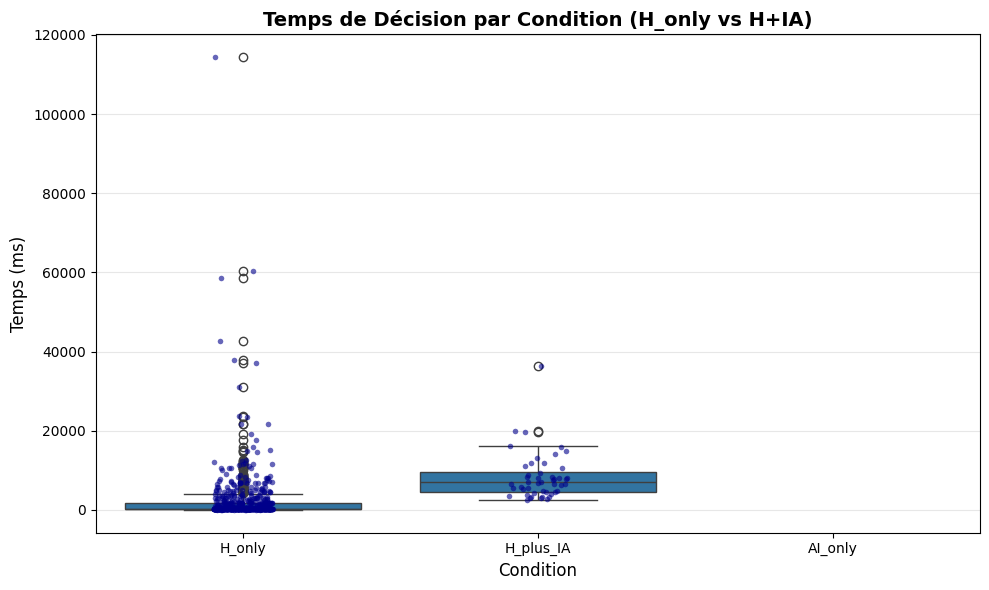


Figure sauvegardée : decision_time_datasets.png

MATRICE CORRÉLATIONS H+IA

Corrélations :
                     user_confidence  correct_bool  decision_time_ms  \
user_confidence                1.000           NaN            -0.159   
correct_bool                     NaN           NaN               NaN   
decision_time_ms              -0.159           NaN             1.000   
uncertainty_encoded            0.097           NaN            -0.244   

                     uncertainty_encoded  
user_confidence                    0.097  
correct_bool                         NaN  
decision_time_ms                  -0.244  
uncertainty_encoded                1.000  


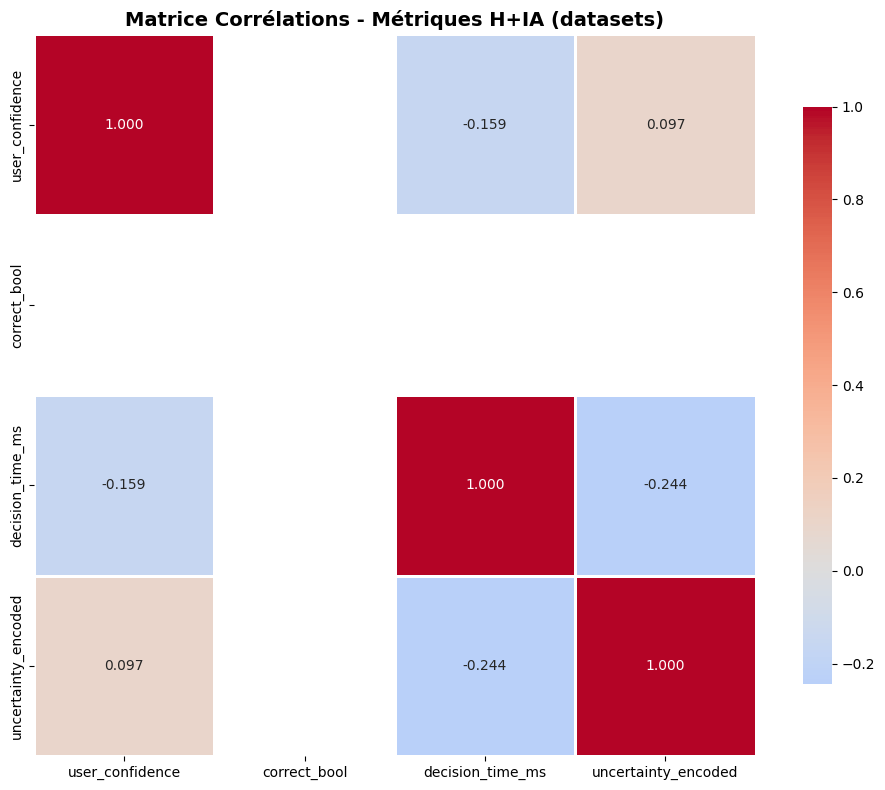


Figure sauvegardée en correlation_heatmap_datasets.png


In [32]:
from scipy.stats import mannwhitneyu
import seaborn as sns

df = datasets['combined']
if df is None:
    print("datasets combined non dispo")
else:
    print("TEMPS DE DÉCISION + CORRÉLATIONS - Adapté datasets")

    # ==========================================================================
    # 1. TEMPS DE DÉCISION (H_only vs H+IA)
    # ==========================================================================
    decision_time_data = df[(df['event_type'] == 'user_action') &
        (df['decision_time_ms'].notna()) &
        (df['condition'].isin(['H_only', 'H_plus_IA']))].copy()
    
    decision_time_data['decision_time_ms'] = pd.to_numeric(decision_time_data['decision_time_ms'], errors='coerce')

    if len(decision_time_data) > 10:
        print("TEMPS DE DÉCISION PAR CONDITION")
        print("="*70)
        
        time_stats = decision_time_data.groupby('condition')['decision_time_ms'].describe()
        print(time_stats)

        h_only_times = decision_time_data[decision_time_data['condition'] == 'H_only']['decision_time_ms'].dropna()
        h_plus_ia_times = decision_time_data[decision_time_data['condition'] == 'H_plus_IA']['decision_time_ms'].dropna()
        
        if len(h_only_times) > 5 and len(h_plus_ia_times) > 5:
            stat, p = mannwhitneyu(h_only_times, h_plus_ia_times, alternative='two-sided')
            print(f"\nMann-Whitney U : U={stat:.2f}, p={p:.4f}")
            print(f" {'Différence significative' if p < 0.05 else 'Pas de différence'}")
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.boxplot(data=decision_time_data, x='condition', y='decision_time_ms', ax=ax)
        sns.stripplot(data=decision_time_data, x='condition', y='decision_time_ms', color='darkblue', size=4, alpha=0.6, ax=ax)
        ax.set_title('Temps de Décision par Condition (H_only vs H+IA)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Condition', fontsize=12)
        ax.set_ylabel('Temps (ms)', fontsize=12)
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('decision_time_datasets.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\nFigure sauvegardée : decision_time_datasets.png")
    else:
        print("Moins de 10 observations pour temps de décision")

    # ==========================================================================
    # 2. HEATMAP CORRÉLATIONS (H+IA seulement)
    # ==========================================================================
    print("\n" + "="*70)
    print("MATRICE CORRÉLATIONS H+IA")
    print("="*70)

    uncertainty_map = {'low': 1, 'medium': 2, 'high': 3, 'mid': 2, 'na': 0, '': 0}
    df['uncertainty_encoded'] = df['ai_uncertainty'].map(uncertainty_map)

    df['correct_bool'] = (df['correct'] == 'Y').astype(float)
    
    corr_metrics = df[(df['event_type'].isin(['submit', 'user_action'])) & (df['condition'] == 'H_plus_IA')][['user_confidence', 'correct_bool', 'decision_time_ms', 'uncertainty_encoded']].dropna()
    
    corr_metrics['decision_time_ms'] = pd.to_numeric(corr_metrics['decision_time_ms'], errors='coerce')
    corr_metrics['user_confidence'] = pd.to_numeric(corr_metrics['user_confidence'], errors='coerce')
    
    if len(corr_metrics) > 5:
        corr_matrix = corr_metrics.corr()
        print("\nCorrélations :")
        print(corr_matrix.round(3))
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
        ax.set_title('Matrice Corrélations - Métriques H+IA (datasets)', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('correlation_heatmap_datasets.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("\nFigure sauvegardée en correlation_heatmap_datasets.png")
        
        strong_corrs = corr_matrix[abs(corr_matrix) > 0.5].stack().reset_index()
        strong_corrs.columns = ['var1', 'var2', 'corr']
        strong_corrs = strong_corrs[(strong_corrs['var1'] != strong_corrs['var2'])]
        if len(strong_corrs) > 0:
            print("\nCorrélations fortes (|r| > 0.5):")
            print(strong_corrs.round(3))
    else:
        print("Moins de 5 observations pour corrélations H+IA")


---
## Tableau récap

In [36]:
from scipy.stats import chi2_contingency

print("Construction tableau synthèse")
summary_rows = []

df = datasets['combined']
submits = df[df['event_type'] == 'submit']

#H1
user_actions_h_only = df[(df['event_type'] == 'user_action') & (df['condition'] == 'H_only')]
h_only_perf_data = []
for idx, action in user_actions_h_only.iterrows():
    trial_id = action['trial_id']
    session_id = action['session_id']
    submit = df[(df['event_type'] == 'submit') & 
                (df['trial_id'] == trial_id) & 
                (df['session_id'] == session_id)]
    if len(submit) > 0 and 'correct' in submit.columns:
        h_only_perf_data.append({'correct': submit['correct'].iloc[0] == 'Y'})
h_only_perf = np.mean([x['correct'] for x in h_only_perf_data]) if h_only_perf_data else 0

h_plus_perf = (submits[submits['condition'] == 'H_plus_IA']['correct'] == 'Y').mean() if len(submits) > 0 else 0
ai_only_perf = (submits[submits['condition'] == 'AI_only']['correct'] == 'Y').mean() if len(submits) > 0 else 0

uplift = (h_plus_perf - max(h_only_perf, ai_only_perf)) / max(h_only_perf, ai_only_perf) * 100 if max(h_only_perf, ai_only_perf) > 0 else 0

summary_rows.append({
    'Hypothèse': 'H1 - Team Uplift',
    'Test': 'Comparaison moyennes',
    'Statistique': f"Uplift = {uplift:.1f}%",
    'P-value': 'N/A',
    'Conclusion': 'VALIDÉE' if uplift > 0 else 'REJETÉE'})

# H2
if 'calib_results' in locals() and calib_results is not None:
    summary_rows.append({
        'Hypothèse': 'H2 - Calibration',
        'Test': 'Pearson correlation',
        'Statistique': f"r = {calib_results['r']:.3f}",
        'P-value': f"{calib_results['p_value']:.4f}",
        'Conclusion': 'VALIDÉE' if (calib_results['r'] > 0.5 and calib_results['p_value'] < 0.05) else 'REJETÉE'
    })
else:
    summary_rows.append({
        'Hypothèse': 'H2 - Calibration', 'Test': 'Pearson correlation',
        'Statistique': 'N/A', 'P-value': 'Non calculé', 'Conclusion': 'À exécuter'
    })

# absention H3
if 'abstention_results' in locals() and abstention_results is not None:
    summary_rows.append({
        'Hypothèse': 'H3 - Abstention',
        'Test': 'Spearman correlation',
        'Statistique': f"ρ = {abstention_results['rho']:.3f}",
        'P-value': f"{abstention_results['p_value']:.4f}",
        'Conclusion': 'VALIDÉE' if (abstention_results['rho'] > 0.6 and abstention_results['p_value'] < 0.05) else 'REJETÉE'
    })
else:
    summary_rows.append({
        'Hypothèse': 'H3 - Abstention', 'Test': 'Spearman correlation',
        'Statistique': 'N/A', 'P-value': 'Non calculé', 'Conclusion': 'À exécuter'
    })

#H4
if 'feedback_results' in locals() and feedback_results is not None:
    summary_rows.append({
        'Hypothèse': 'H4 - Convergence',
        'Test': 'Rolling std analysis',
        'Statistique': f"σ = {feedback_results['final_std']:.4f}",
        'P-value': 'N/A',
        'Conclusion': 'VALIDÉE' if feedback_results['converged'] else 'REJETÉE'
    })
else:
    summary_rows.append({
        'Hypothèse': 'H4 - Convergence', 'Test': 'Rolling std analysis',
        'Statistique': 'N/A', 'P-value': 'N/A', 'Conclusion': '⏳ À exécuter'
    })

# H5
actions_hia = df[(df['event_type'] == 'user_action') & (df['condition'] == 'H_plus_IA')]
if len(actions_hia) > 10:
    contingency = pd.crosstab(actions_hia['ai_uncertainty'], actions_hia['human_action'])
    chi2, p_chi2, dof, expected = chi2_contingency(contingency)

    unc_order = ['low', 'medium', 'mid', 'high']
    accept_rates = []
    for unc in unc_order:
        row = contingency.loc[unc] if unc in contingency.index else pd.Series({'accept': 0})
        accept_rate = row.get('accept', 0) / row.sum() if row.sum() > 0 else 0
        accept_rates.append(accept_rate)
    
    is_decreasing = np.corrcoef(range(len(accept_rates)), accept_rates)[0,1] < 0
    
    summary_rows.append({
        'Hypothèse': 'H5 - Reliance',
        'Test': 'Chi² + tendance décroissante',
        'Statistique': f"χ² = {chi2:.3f}",
        'P-value': f"{p_chi2:.4f}",
        'Conclusion': 'VALIDÉE' if (p_chi2 < 0.05 and is_decreasing) else 'REJETÉE'
    })
else:
    summary_rows.append({
        'Hypothèse': 'H5 - Reliance', 'Test': 'Chi² independence',
        'Statistique': 'N/A', 'P-value': 'Non calculé', 'Conclusion': 'À exécuter'})

summary_df = pd.DataFrame(summary_rows)
print("\n" + "="*80)
print("TABLEAU RÉCAPITULATIF DES 5 HYPOTHÈSES")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

print("\n" + "="*80)
print("TABLEAU RÉCAPITULATIF DES 5 HYPOTHÈSES")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

summary_df.to_csv('hypothesis_summary_datasets.csv', index=False)
print("hypothesis_summary_datasets.csv")

try:
    summary_df.to_excel('hypothesis_summary_datasets.xlsx', index=False)
    print("hypothesis_summary_datasets.xlsx")
except ImportError as e:
    print(f"Excel ignoré ({e}) → CSV + Markdown seulement")
print("\nSYNTHÈSE TERMINÉE !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")



Construction tableau synthèse

TABLEAU RÉCAPITULATIF DES 5 HYPOTHÈSES
       Hypothèse                         Test    Statistique P-value Conclusion
H1 - Team Uplift         Comparaison moyennes Uplift = 50.5%     N/A    VALIDÉE
H2 - Calibration          Pearson correlation      r = 0.217  0.1023    REJETÉE
 H3 - Abstention         Spearman correlation      ρ = 0.975  0.0048    VALIDÉE
H4 - Convergence         Rolling std analysis     σ = 0.2928     N/A    VALIDÉE
   H5 - Reliance Chi² + tendance décroissante     χ² = 4.375  0.0365    VALIDÉE

TABLEAU RÉCAPITULATIF DES 5 HYPOTHÈSES
       Hypothèse                         Test    Statistique P-value Conclusion
H1 - Team Uplift         Comparaison moyennes Uplift = 50.5%     N/A    VALIDÉE
H2 - Calibration          Pearson correlation      r = 0.217  0.1023    REJETÉE
 H3 - Abstention         Spearman correlation      ρ = 0.975  0.0048    VALIDÉE
H4 - Convergence         Rolling std analysis     σ = 0.2928     N/A    VALIDÉE
   H5 - Re

### Hover prediction

Nombre de hover prediction (Thoth AI affiché en prédictions par fond spécifique, sans pour autant recommander)

Consultations Thoth (Hover_prediction)
5 utilisateurs
Total: 278 consultations
⏱Moyenne: 55.6


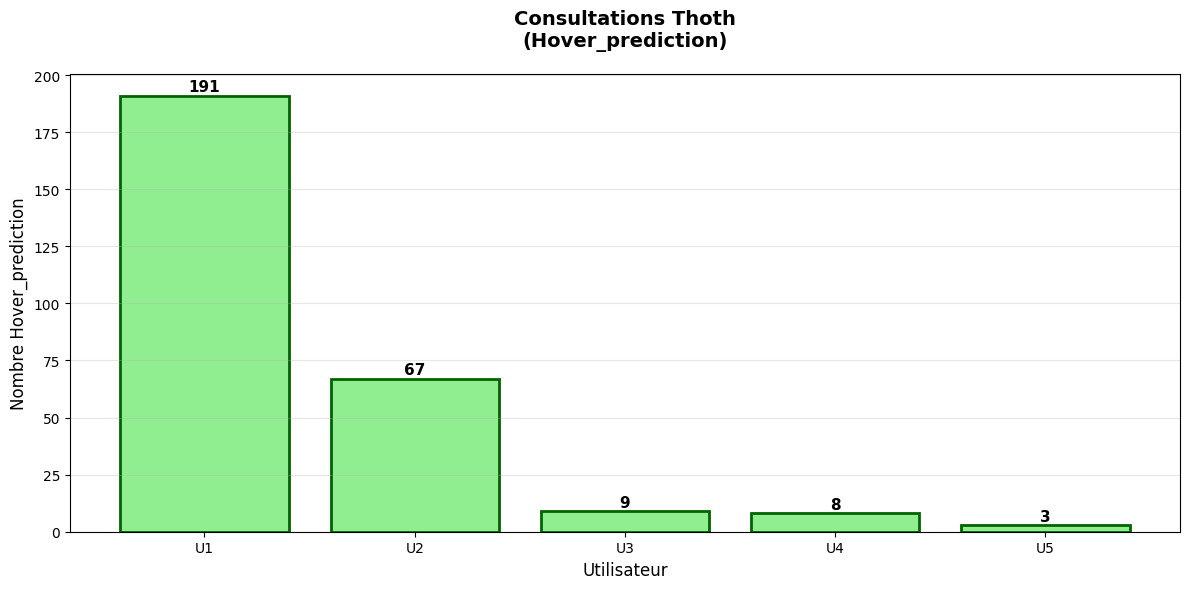

   session_id  nb_hover
 3.294668e+06       191
 9.325698e+07        67
 1.267113e+09         9
-9.253894e+08         8
-1.253460e+09         3


In [39]:

import matplotlib.pyplot as plt
import pandas as pd

df = datasets['combined']
print("Consultations Thoth (Hover_prediction)")

hover_user = df[(df['event_type'] == 'hover_prediction')].groupby('session_id').size().reset_index(name='nb_hover')

print(f"{len(hover_user)} utilisateurs")
print(f"Total: {hover_user['nb_hover'].sum()} consultations")
print(f"⏱Moyenne: {hover_user['nb_hover'].mean():.1f}")

top_users = hover_user.nlargest(10, 'nb_hover')

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(top_users)), top_users['nb_hover'], color='lightgreen', edgecolor='darkgreen', linewidth=2)
plt.title('Consultations Thoth\n(Hover_prediction)', fontweight='bold', fontsize=14, pad=20)
plt.xlabel('Utilisateur', fontsize=12)
plt.ylabel('Nombre Hover_prediction', fontsize=12)

plt.xticks(range(len(top_users)), [f"U{i+1}" for i in range(len(top_users))], rotation=0)

for i, v in enumerate(top_users['nb_hover']):
    plt.text(i, v + max(top_users['nb_hover'])*0.01, f'{int(v)}', ha='center', fontweight='bold', fontsize=11)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('hover_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

print(top_users[['session_id', 'nb_hover']].round(0).to_string(index=False))

top_users.to_csv('hover_users.csv', index=False)
hover_user.to_csv('hover_all_users.csv', index=False)